In [2]:
import numpy as np
import torch
# from datasets.mnist1d import load_MNIST1D
from datasets.control import get_mixture_distribution, load_control
import os
import matplotlib.pyplot as plt

In [3]:
mixture_list = [
    # uniform between [-10, -5] and [5, 10] (for 2D data)
    ("uniform",
     np.array([-10.0, -5.0, -10, -10]),
     np.array([5.0, 10.0, -5, 5])),

    # normal with mean [10, 5, -5] and std [2, 12, 1]
    ("normal",
     np.array([10.0,  5.0, -5.0, -5]),
     np.array([ 2.0, 12.0,  1.0, 1])),

    # normal centered at 0 with unit variance in all dims
    ("normal",
     np.array([0.0, 0.0, 0.0, 0]),
     np.array([1.0, 1.0, 1.0, 1])),

    # normal with mean [3, 6, 2] and std [4, 5, 3]
    ("normal",
     np.array([3.0, 6.0, 2.0, 2]),
     np.array([4.0, 5.0, 3.0, 3])),

    # laplace centered at [4, 4, 4] with scale 1
    ("laplace",
     np.array([4.0, 4.0, 4.0, 4]),
     np.array([1.0, 1.0, 1.0, 1])),

    # normal centered at -5 with std 3 in all dims
    ("normal",
     np.array([-5.0, -5.0, -5.0, -5]),
     np.array([3.0, 3.0, 3.0, 3])),

    # exponential with scale=1 in all dims, then shifted by -5
    ("exponential",
     np.array([1.0, 1.0, 1.0, 1]),    # scale
     np.array([-5.0, -5.0, -5.0, -5])), # shift
]


# mixture_list = [
#     ('uniform', np.array([-10.,  -5.]), np.array([ 5., 10.])),
#     ('normal', np.array([10.,  5.]), np.array([ 2., 12.])),
#     ('normal', np.array([0., 0.]), np.array([1., 1.])),
#     ('normal', np.array([3., 6.]), np.array([4., 5.])),
#     ('laplace', np.array([4., 4.]), np.array([1., 1.])),
#     ('normal', np.array([-5., -5.]), np.array([3., 3.])),
#     ('exponential', np.array([1., 1.]), np.array([-5., -5.]))
# ]

# mixture_list = [
#     ('normal', np.array([0., 0.]), np.array([1., 1.])),
# ]

weights = [0.1, 0.2, 0.2, 0.1, 0.1, 0.2, 0.1]
# weights = [1]
control_data = get_mixture_distribution(mixture_list, weights, size=(10000, 4))

# Train GMMN

## Parameters

In [4]:
model_dir = "./model_weights"

BATCH_SIZE = 1000 # taken from original paper
# trainloader, testloader, min_value, max_value = load_MNIST1D(batch_size = BATCH_SIZE)
# trainloader, testloader = load_MNIST(batch_size = BATCH_SIZE, size=7, flatten=True)
trainloader, testloader, min_value, max_value = load_control(control_data, batch_size=1000)
for batch_inputs, batch_targets in trainloader:
    # Do training step here
    print(batch_inputs.shape, batch_targets.shape)
    break
N_INP = next(iter(trainloader))[0].shape[1]
NOISE_SIZE = 10
ENCODED_SIZE = 10
N_ENCODER_EPOCHS = 2000
N_GEN_EPOCHS = 2000

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.Size([1000, 4]) torch.Size([1000, 4])


## Train Autoencoder


In [5]:
from models.gmmn.train_autoencoder import train_autoencoder
from visualization.loss import plot_loss

ENCODER_SAVE_PATH = model_dir + "/autoencoder_control-presentation.pth"
autoencoder, losses_autoencoder = train_autoencoder(trainloader, N_INP, ENCODED_SIZE, N_ENCODER_EPOCHS, device, ENCODER_SAVE_PATH)
plot_loss(losses_autoencoder, title="Autoencoder Loss")

Autoencoder Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

Loaded saved autoencoder model
Autoencoder has been successfully trained



/home/vasil/Desktop/temp/mmd-gan-2/visualization/loss.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


## Continue with GMMN


In [6]:
from models.gmmn.train_gmmn import train_gmmn
sigmas = [0.01, 0.1, 0.5,  1, 2, 4, 5, 8, 10, 16, 20, 50]
GMMN_SAVE_PATH = model_dir + "/gmmn_standard_normal_expanded_sigmas.pth"


gmm_net, losses_gmmn = train_gmmn(
    trainloader, autoencoder, sigmas, ENCODED_SIZE, NOISE_SIZE, BATCH_SIZE, N_GEN_EPOCHS, device, GMMN_SAVE_PATH
)

plot_loss(losses_gmmn, title="GMMN Loss with Expanded Sigmas")

Loaded previously saved GMM Network and losses from checkpoint.


Using device: cuda
Starting training...


Training Epochs:   1%|          | 48/4000 [00:32<41:08,  1.60it/s] 

[48/4000][66/125] Iter: 500 Loss_D: 0.375571 Loss_G: 0.359059 |gD|: 4.0898e+00 |gG|: 2.9496e+00 Time(min): 0.54


Training Epochs:   1%|          | 49/4000 [00:32<42:08,  1.56it/s]

[48/4000][125/125] Iter: 500 Loss_D: 0.294675 Loss_G: 0.359059 |gD|: 8.0570e+00 |gG|: 2.9496e+00 Time(min): 0.55


Training Epochs:   2%|▏         | 75/4000 [00:49<42:31,  1.54it/s]

[74/4000][90/125] Iter: 1000 Loss_D: 0.318680 Loss_G: 0.377858 |gD|: 4.2058e+00 |gG|: 4.2016e+00 Time(min): 0.82
[74/4000][125/125] Iter: 1000 Loss_D: 0.228994 Loss_G: 0.377858 |gD|: 7.1929e+00 |gG|: 4.2016e+00 Time(min): 0.82


Training Epochs:   3%|▎         | 101/4000 [01:06<43:02,  1.51it/s]

[100/4000][90/125] Iter: 1500 Loss_D: 0.317729 Loss_G: 0.248674 |gD|: 6.0537e+00 |gG|: 3.9657e+00 Time(min): 1.10
[100/4000][125/125] Iter: 1500 Loss_D: 0.273425 Loss_G: 0.248674 |gD|: 3.4903e+00 |gG|: 3.9657e+00 Time(min): 1.11


Training Epochs:   3%|▎         | 126/4000 [01:23<45:04,  1.43it/s]

[126/4000][90/125] Iter: 2000 Loss_D: 0.326152 Loss_G: 0.285315 |gD|: 4.8667e+00 |gG|: 3.9743e+00 Time(min): 1.40


Training Epochs:   3%|▎         | 127/4000 [01:23<45:27,  1.42it/s]

[126/4000][125/125] Iter: 2000 Loss_D: 0.314849 Loss_G: 0.285315 |gD|: 4.2547e+00 |gG|: 3.9743e+00 Time(min): 1.40


Training Epochs:   4%|▍         | 153/4000 [01:42<43:37,  1.47it/s]

[152/4000][90/125] Iter: 2500 Loss_D: 0.228726 Loss_G: 0.389926 |gD|: 9.3334e+00 |gG|: 4.4485e+00 Time(min): 1.70
[152/4000][125/125] Iter: 2500 Loss_D: 0.245676 Loss_G: 0.389926 |gD|: 4.8377e+00 |gG|: 4.4485e+00 Time(min): 1.71


Training Epochs:   4%|▍         | 179/4000 [01:59<41:19,  1.54it/s]

[178/4000][90/125] Iter: 3000 Loss_D: 0.335861 Loss_G: 0.326890 |gD|: 6.7554e+00 |gG|: 4.1166e+00 Time(min): 1.99
[178/4000][125/125] Iter: 3000 Loss_D: 0.374638 Loss_G: 0.326890 |gD|: 5.0320e+00 |gG|: 4.1166e+00 Time(min): 1.99


Training Epochs:   5%|▌         | 205/4000 [02:16<43:46,  1.44it/s]

[204/4000][90/125] Iter: 3500 Loss_D: 0.218900 Loss_G: 0.205558 |gD|: 3.9873e+00 |gG|: 3.4702e+00 Time(min): 2.28
[204/4000][125/125] Iter: 3500 Loss_D: 0.268491 Loss_G: 0.205558 |gD|: 7.3085e+00 |gG|: 3.4702e+00 Time(min): 2.28


Training Epochs:   6%|▌         | 231/4000 [02:35<42:17,  1.49it/s]

[230/4000][90/125] Iter: 4000 Loss_D: 0.342448 Loss_G: 0.294807 |gD|: 4.5672e+00 |gG|: 4.3479e+00 Time(min): 2.58
[230/4000][125/125] Iter: 4000 Loss_D: 0.240838 Loss_G: 0.294807 |gD|: 1.0462e+01 |gG|: 4.3479e+00 Time(min): 2.59


Training Epochs:   6%|▋         | 257/4000 [02:52<41:12,  1.51it/s]

[256/4000][90/125] Iter: 4500 Loss_D: 0.308074 Loss_G: 0.252560 |gD|: 6.2749e+00 |gG|: 2.7087e+00 Time(min): 2.87
[256/4000][125/125] Iter: 4500 Loss_D: 0.207080 Loss_G: 0.252560 |gD|: 6.4271e+00 |gG|: 2.7087e+00 Time(min): 2.87


Training Epochs:   7%|▋         | 282/4000 [03:09<43:27,  1.43it/s]

[282/4000][90/125] Iter: 5000 Loss_D: 0.254044 Loss_G: 0.384187 |gD|: 5.8101e+00 |gG|: 4.2923e+00 Time(min): 3.16


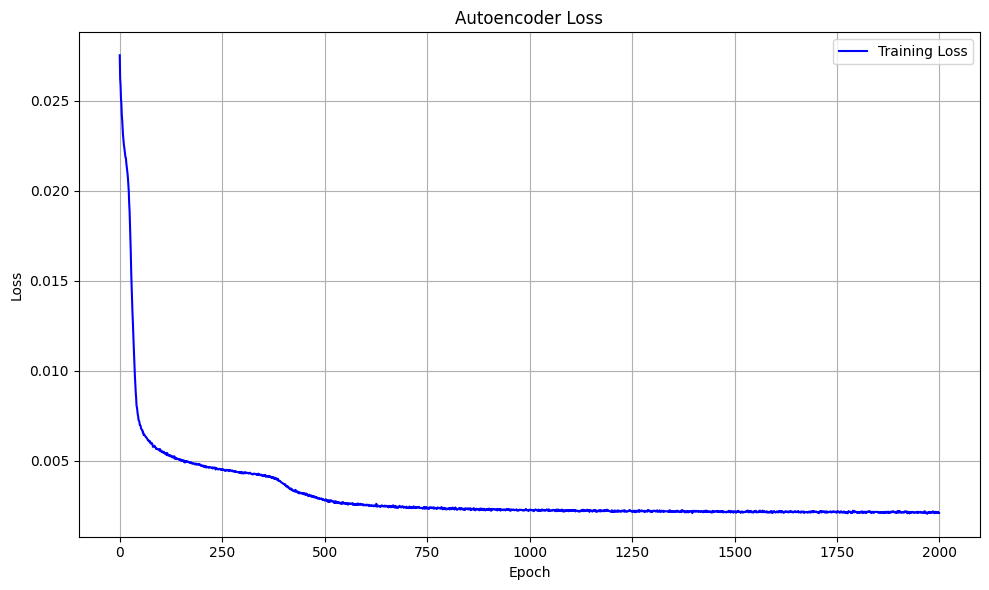

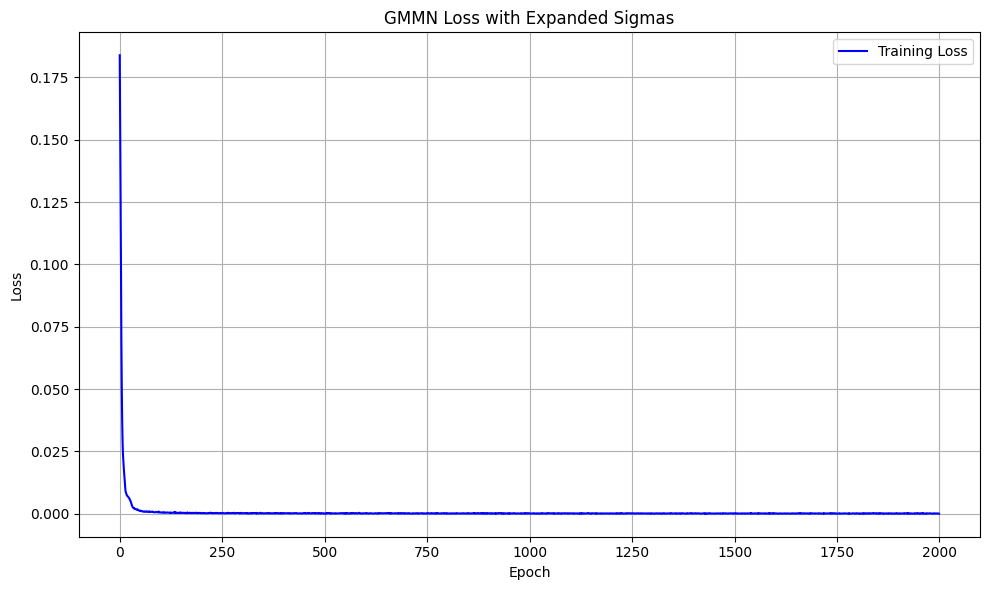

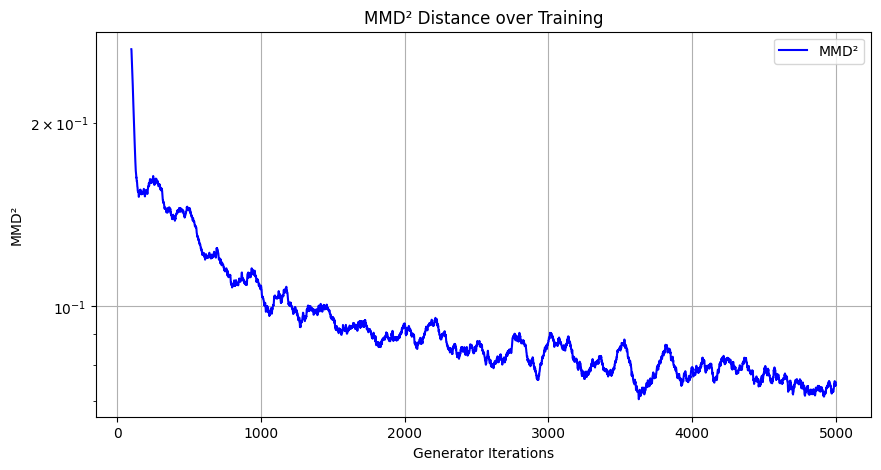

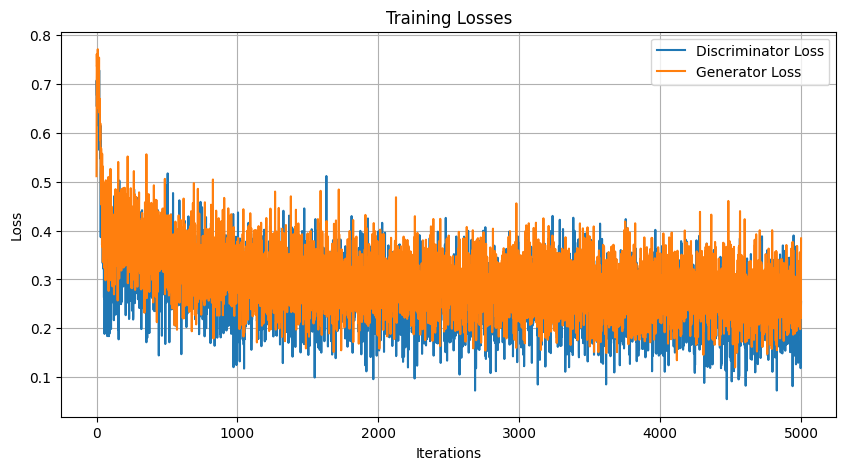

[282/4000][125/125] Iter: 5000 Loss_D: 0.285988 Loss_G: 0.384187 |gD|: 4.5374e+00 |gG|: 4.2923e+00 Time(min): 3.18


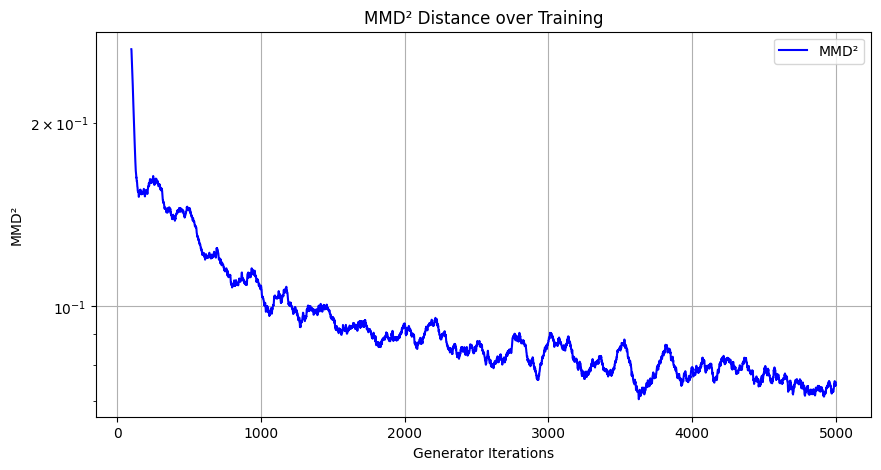

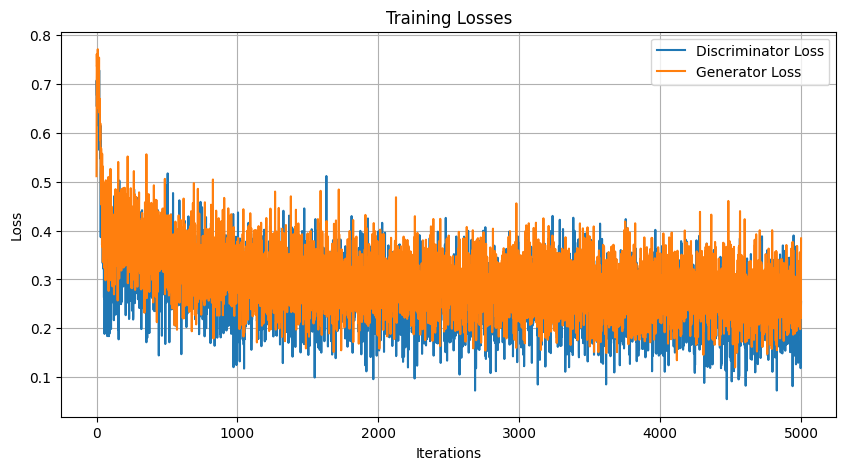

Training Epochs:   8%|▊         | 308/4000 [03:29<43:22,  1.42it/s]  

[308/4000][90/125] Iter: 5500 Loss_D: 0.203000 Loss_G: 0.301167 |gD|: 5.0228e+00 |gG|: 5.5816e+00 Time(min): 3.50


Training Epochs:   8%|▊         | 309/4000 [03:30<43:25,  1.42it/s]

[308/4000][125/125] Iter: 5500 Loss_D: 0.218476 Loss_G: 0.301167 |gD|: 6.4208e+00 |gG|: 5.5816e+00 Time(min): 3.50


Training Epochs:   8%|▊         | 334/4000 [03:47<43:06,  1.42it/s]

[334/4000][90/125] Iter: 6000 Loss_D: 0.276571 Loss_G: 0.198519 |gD|: 3.4299e+00 |gG|: 2.8589e+00 Time(min): 3.80


Training Epochs:   8%|▊         | 335/4000 [03:48<43:17,  1.41it/s]

[334/4000][125/125] Iter: 6000 Loss_D: 0.188275 Loss_G: 0.198519 |gD|: 7.8550e+00 |gG|: 2.8589e+00 Time(min): 3.81


Training Epochs:   9%|▉         | 361/4000 [04:06<40:46,  1.49it/s]

[360/4000][90/125] Iter: 6500 Loss_D: 0.264081 Loss_G: 0.276688 |gD|: 9.4010e+00 |gG|: 6.1680e+00 Time(min): 4.10
[360/4000][125/125] Iter: 6500 Loss_D: 0.140803 Loss_G: 0.276688 |gD|: 1.1135e+01 |gG|: 6.1680e+00 Time(min): 4.10


Training Epochs:  10%|▉         | 387/4000 [04:23<40:02,  1.50it/s]

[386/4000][90/125] Iter: 7000 Loss_D: 0.226669 Loss_G: 0.189926 |gD|: 4.7274e+00 |gG|: 3.6509e+00 Time(min): 4.39
[386/4000][125/125] Iter: 7000 Loss_D: 0.270880 Loss_G: 0.189926 |gD|: 6.9206e+00 |gG|: 3.6509e+00 Time(min): 4.39


Training Epochs:  10%|█         | 413/4000 [04:40<39:52,  1.50it/s]

[412/4000][90/125] Iter: 7500 Loss_D: 0.156667 Loss_G: 0.267054 |gD|: 8.0484e+00 |gG|: 3.8682e+00 Time(min): 4.68
[412/4000][125/125] Iter: 7500 Loss_D: 0.191697 Loss_G: 0.267054 |gD|: 5.5878e+00 |gG|: 3.8682e+00 Time(min): 4.68


Training Epochs:  11%|█         | 439/4000 [04:58<40:37,  1.46it/s]

[438/4000][90/125] Iter: 8000 Loss_D: 0.207873 Loss_G: 0.255875 |gD|: 3.5059e+00 |gG|: 4.8527e+00 Time(min): 4.98
[438/4000][125/125] Iter: 8000 Loss_D: 0.222309 Loss_G: 0.255875 |gD|: 5.4005e+00 |gG|: 4.8527e+00 Time(min): 4.98


Training Epochs:  12%|█▏        | 465/4000 [05:16<39:26,  1.49it/s]

[464/4000][90/125] Iter: 8500 Loss_D: 0.249476 Loss_G: 0.167156 |gD|: 4.1130e+00 |gG|: 4.3921e+00 Time(min): 5.28
[464/4000][125/125] Iter: 8500 Loss_D: 0.226571 Loss_G: 0.167156 |gD|: 3.3968e+00 |gG|: 4.3921e+00 Time(min): 5.28


Training Epochs:  12%|█▏        | 491/4000 [05:34<39:01,  1.50it/s]

[490/4000][90/125] Iter: 9000 Loss_D: 0.212804 Loss_G: 0.159798 |gD|: 5.1969e+00 |gG|: 3.2776e+00 Time(min): 5.57
[490/4000][125/125] Iter: 9000 Loss_D: 0.242822 Loss_G: 0.159798 |gD|: 4.9431e+00 |gG|: 3.2776e+00 Time(min): 5.58


Training Epochs:  13%|█▎        | 517/4000 [05:52<38:35,  1.50it/s]

[516/4000][90/125] Iter: 9500 Loss_D: 0.219460 Loss_G: 0.251149 |gD|: 6.3987e+00 |gG|: 3.9376e+00 Time(min): 5.87
[516/4000][125/125] Iter: 9500 Loss_D: 0.110841 Loss_G: 0.251149 |gD|: 4.4569e+00 |gG|: 3.9376e+00 Time(min): 5.87


Training Epochs:  14%|█▎        | 542/4000 [06:08<38:37,  1.49it/s]

[542/4000][90/125] Iter: 10000 Loss_D: 0.291323 Loss_G: 0.224173 |gD|: 7.3055e+00 |gG|: 4.2723e+00 Time(min): 6.16


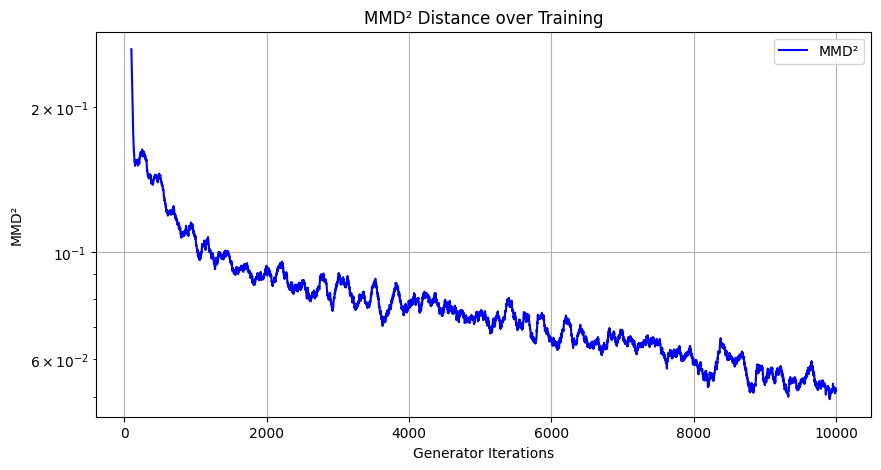

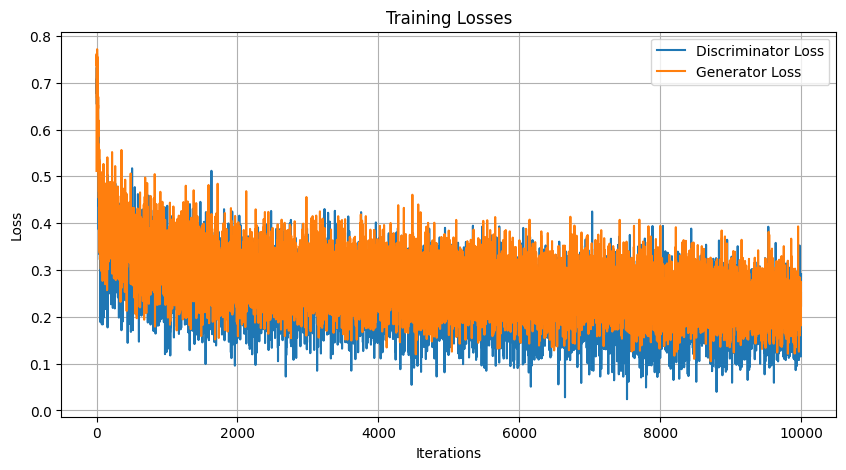

[542/4000][125/125] Iter: 10000 Loss_D: 0.099167 Loss_G: 0.224173 |gD|: 6.6494e+00 |gG|: 4.2723e+00 Time(min): 6.18


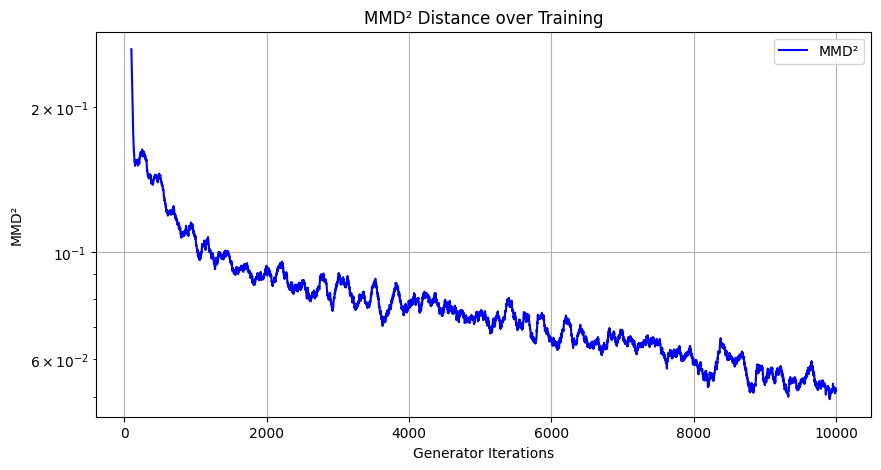

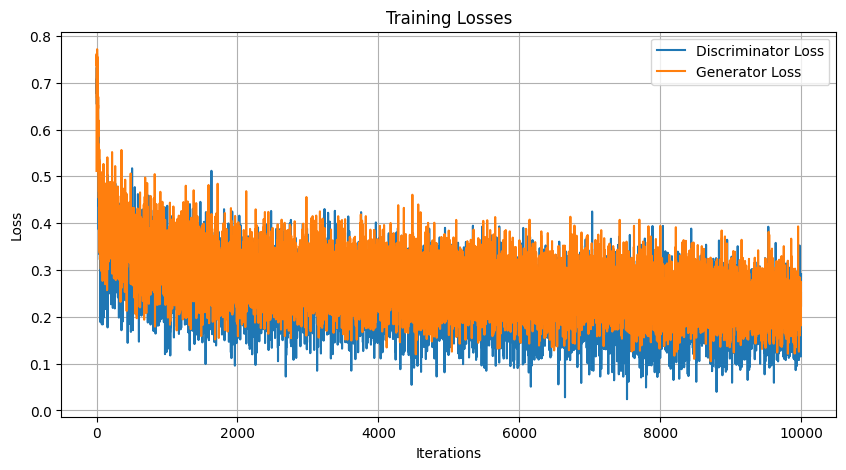

Training Epochs:  14%|█▍        | 569/4000 [06:28<38:39,  1.48it/s]  

[568/4000][90/125] Iter: 10500 Loss_D: 0.278379 Loss_G: 0.269237 |gD|: 4.8787e+00 |gG|: 3.6729e+00 Time(min): 6.47
[568/4000][125/125] Iter: 10500 Loss_D: 0.192408 Loss_G: 0.269237 |gD|: 5.0293e+00 |gG|: 3.6729e+00 Time(min): 6.48


Training Epochs:  15%|█▍        | 595/4000 [06:45<38:04,  1.49it/s]

[594/4000][90/125] Iter: 11000 Loss_D: 0.217069 Loss_G: 0.191485 |gD|: 8.8585e+00 |gG|: 3.7789e+00 Time(min): 6.76
[594/4000][125/125] Iter: 11000 Loss_D: 0.258429 Loss_G: 0.191485 |gD|: 4.6445e+00 |gG|: 3.7789e+00 Time(min): 6.76


Training Epochs:  16%|█▌        | 620/4000 [07:02<41:04,  1.37it/s]

[620/4000][90/125] Iter: 11500 Loss_D: 0.251679 Loss_G: 0.266022 |gD|: 5.5483e+00 |gG|: 4.4221e+00 Time(min): 7.06


Training Epochs:  16%|█▌        | 621/4000 [07:03<40:48,  1.38it/s]

[620/4000][125/125] Iter: 11500 Loss_D: 0.101879 Loss_G: 0.266022 |gD|: 8.5337e+00 |gG|: 4.4221e+00 Time(min): 7.06


Training Epochs:  16%|█▌        | 647/4000 [07:21<37:43,  1.48it/s]

[646/4000][90/125] Iter: 12000 Loss_D: 0.160543 Loss_G: 0.233227 |gD|: 5.4449e+00 |gG|: 4.6670e+00 Time(min): 7.35
[646/4000][125/125] Iter: 12000 Loss_D: 0.160758 Loss_G: 0.233227 |gD|: 3.6781e+00 |gG|: 4.6670e+00 Time(min): 7.36


Training Epochs:  17%|█▋        | 673/4000 [07:39<38:23,  1.44it/s]

[672/4000][90/125] Iter: 12500 Loss_D: 0.190239 Loss_G: 0.216376 |gD|: 4.7929e+00 |gG|: 4.3853e+00 Time(min): 7.65
[672/4000][125/125] Iter: 12500 Loss_D: 0.083510 Loss_G: 0.216376 |gD|: 2.6232e+00 |gG|: 4.3853e+00 Time(min): 7.65


Training Epochs:  17%|█▋        | 699/4000 [07:56<36:25,  1.51it/s]

[698/4000][90/125] Iter: 13000 Loss_D: 0.253319 Loss_G: 0.232928 |gD|: 2.7926e+00 |gG|: 2.5717e+00 Time(min): 7.94
[698/4000][125/125] Iter: 13000 Loss_D: 0.145563 Loss_G: 0.232928 |gD|: 5.5235e+00 |gG|: 2.5717e+00 Time(min): 7.94


Training Epochs:  18%|█▊        | 725/4000 [08:14<37:07,  1.47it/s]

[724/4000][90/125] Iter: 13500 Loss_D: 0.186867 Loss_G: 0.246355 |gD|: 3.0293e+00 |gG|: 3.6001e+00 Time(min): 8.24
[724/4000][125/125] Iter: 13500 Loss_D: 0.224084 Loss_G: 0.246355 |gD|: 4.3572e+00 |gG|: 3.6001e+00 Time(min): 8.24


Training Epochs:  19%|█▉        | 751/4000 [08:32<36:39,  1.48it/s]

[750/4000][90/125] Iter: 14000 Loss_D: 0.224196 Loss_G: 0.271337 |gD|: 1.5580e+00 |gG|: 3.7006e+00 Time(min): 8.53
[750/4000][125/125] Iter: 14000 Loss_D: 0.213496 Loss_G: 0.271337 |gD|: 5.6034e+00 |gG|: 3.7006e+00 Time(min): 8.54


Training Epochs:  19%|█▉        | 777/4000 [08:50<36:42,  1.46it/s]

[776/4000][90/125] Iter: 14500 Loss_D: 0.253873 Loss_G: 0.272509 |gD|: 3.1475e+00 |gG|: 3.4451e+00 Time(min): 8.83
[776/4000][125/125] Iter: 14500 Loss_D: 0.193737 Loss_G: 0.272509 |gD|: 8.9609e+00 |gG|: 3.4451e+00 Time(min): 8.83


Training Epochs:  20%|██        | 802/4000 [09:07<37:39,  1.42it/s]

[802/4000][90/125] Iter: 15000 Loss_D: 0.222165 Loss_G: 0.196943 |gD|: 2.7730e+00 |gG|: 2.8739e+00 Time(min): 9.13


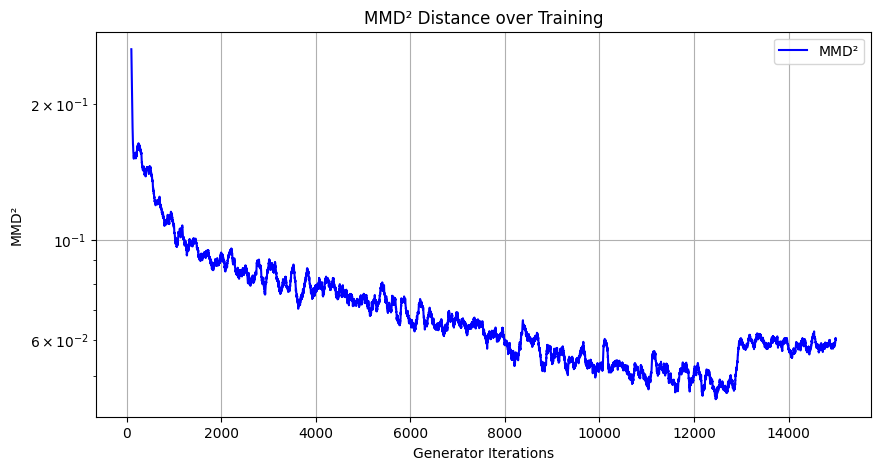

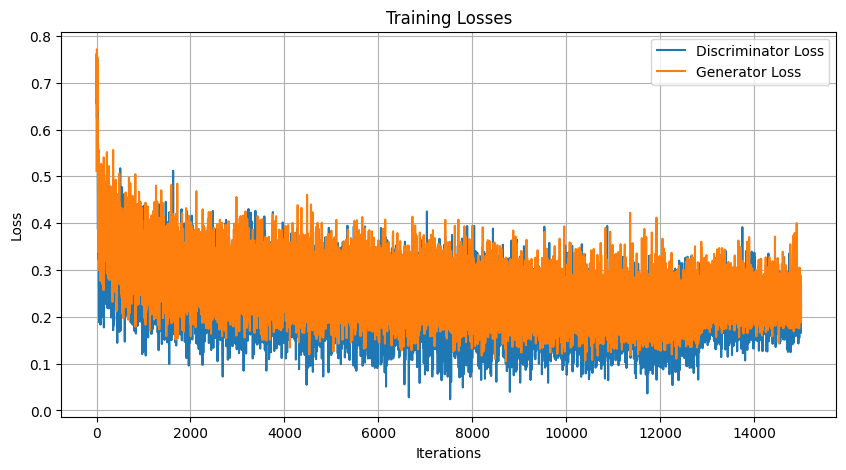

[802/4000][125/125] Iter: 15000 Loss_D: 0.243991 Loss_G: 0.196943 |gD|: 2.5963e+00 |gG|: 2.8739e+00 Time(min): 9.15


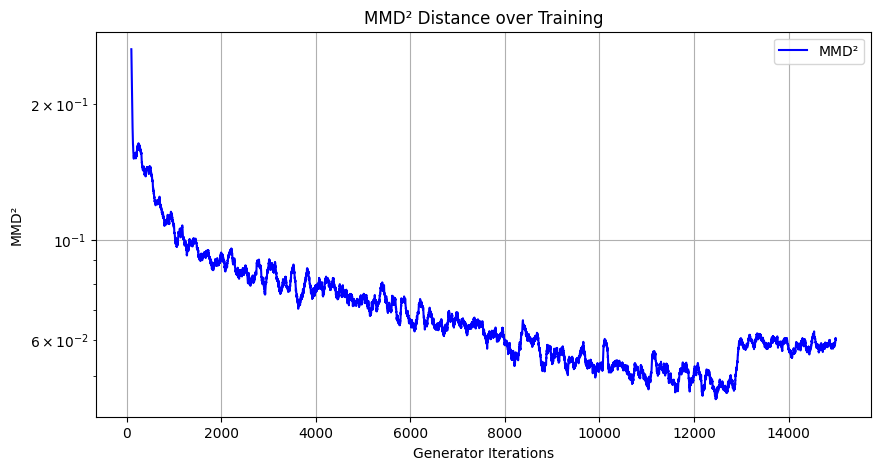

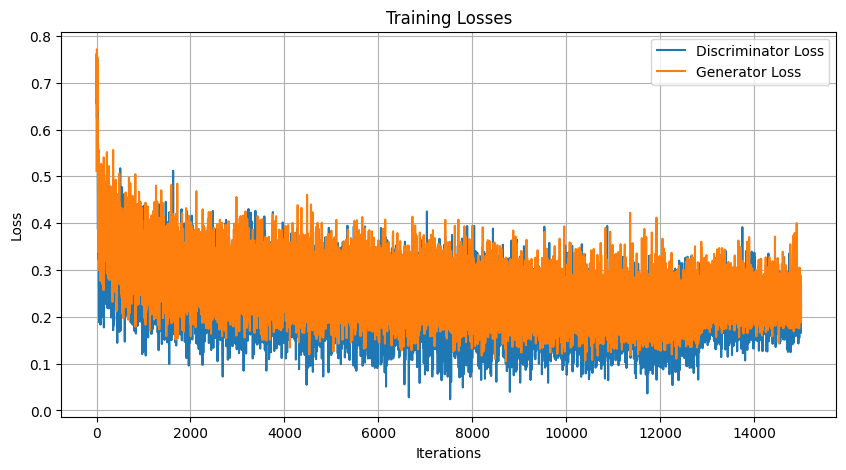

Training Epochs:  21%|██        | 829/4000 [09:28<36:39,  1.44it/s]  

[828/4000][90/125] Iter: 15500 Loss_D: 0.192154 Loss_G: 0.258351 |gD|: 1.8061e+00 |gG|: 2.8902e+00 Time(min): 9.46
[828/4000][125/125] Iter: 15500 Loss_D: 0.225320 Loss_G: 0.258351 |gD|: 4.2089e+00 |gG|: 2.8902e+00 Time(min): 9.47


Training Epochs:  21%|██▏       | 855/4000 [09:45<34:59,  1.50it/s]

[854/4000][90/125] Iter: 16000 Loss_D: 0.231955 Loss_G: 0.250944 |gD|: 6.3683e+00 |gG|: 3.7156e+00 Time(min): 9.76
[854/4000][125/125] Iter: 16000 Loss_D: 0.283412 Loss_G: 0.250944 |gD|: 4.9774e+00 |gG|: 3.7156e+00 Time(min): 9.76


Training Epochs:  22%|██▏       | 881/4000 [10:03<34:47,  1.49it/s]

[880/4000][90/125] Iter: 16500 Loss_D: 0.224076 Loss_G: 0.286320 |gD|: 3.9791e+00 |gG|: 2.9038e+00 Time(min): 10.05
[880/4000][125/125] Iter: 16500 Loss_D: 0.234267 Loss_G: 0.286320 |gD|: 2.9015e+00 |gG|: 2.9038e+00 Time(min): 10.05


Training Epochs:  23%|██▎       | 907/4000 [10:20<34:42,  1.49it/s]

[906/4000][90/125] Iter: 17000 Loss_D: 0.203067 Loss_G: 0.219081 |gD|: 4.2503e+00 |gG|: 3.1742e+00 Time(min): 10.34
[906/4000][125/125] Iter: 17000 Loss_D: 0.206465 Loss_G: 0.219081 |gD|: 2.6833e+00 |gG|: 3.1742e+00 Time(min): 10.34


Training Epochs:  23%|██▎       | 933/4000 [10:37<34:18,  1.49it/s]

[932/4000][90/125] Iter: 17500 Loss_D: 0.200169 Loss_G: 0.209075 |gD|: 3.7894e+00 |gG|: 3.9962e+00 Time(min): 10.62
[932/4000][125/125] Iter: 17500 Loss_D: 0.200719 Loss_G: 0.209075 |gD|: 1.6945e+00 |gG|: 3.9962e+00 Time(min): 10.63


Training Epochs:  24%|██▍       | 959/4000 [10:55<36:03,  1.41it/s]

[958/4000][90/125] Iter: 18000 Loss_D: 0.187299 Loss_G: 0.207036 |gD|: 6.4960e+00 |gG|: 3.1197e+00 Time(min): 10.93
[958/4000][125/125] Iter: 18000 Loss_D: 0.197152 Loss_G: 0.207036 |gD|: 5.4314e+00 |gG|: 3.1197e+00 Time(min): 10.93


Training Epochs:  25%|██▍       | 985/4000 [11:14<35:02,  1.43it/s]

[984/4000][90/125] Iter: 18500 Loss_D: 0.223275 Loss_G: 0.253503 |gD|: 3.6808e+00 |gG|: 3.8949e+00 Time(min): 11.23
[984/4000][125/125] Iter: 18500 Loss_D: 0.227723 Loss_G: 0.253503 |gD|: 4.0814e+00 |gG|: 3.8949e+00 Time(min): 11.24


Training Epochs:  25%|██▌       | 1011/4000 [11:32<34:28,  1.44it/s]

[1010/4000][90/125] Iter: 19000 Loss_D: 0.181356 Loss_G: 0.179464 |gD|: 3.0230e+00 |gG|: 2.5856e+00 Time(min): 11.53
[1010/4000][125/125] Iter: 19000 Loss_D: 0.252990 Loss_G: 0.179464 |gD|: 5.2777e+00 |gG|: 2.5856e+00 Time(min): 11.54


Training Epochs:  26%|██▌       | 1036/4000 [11:49<34:38,  1.43it/s]

[1036/4000][90/125] Iter: 19500 Loss_D: 0.271666 Loss_G: 0.245938 |gD|: 7.0591e+00 |gG|: 2.6807e+00 Time(min): 11.84
[1036/4000][125/125] Iter: 19500 Loss_D: 0.213859 Loss_G: 0.245938 |gD|: 3.2570e+00 |gG|: 2.6807e+00 Time(min): 11.84


Training Epochs:  27%|██▋       | 1062/4000 [12:07<34:07,  1.43it/s]

[1062/4000][90/125] Iter: 20000 Loss_D: 0.246298 Loss_G: 0.269019 |gD|: 6.4221e+00 |gG|: 3.7388e+00 Time(min): 12.14


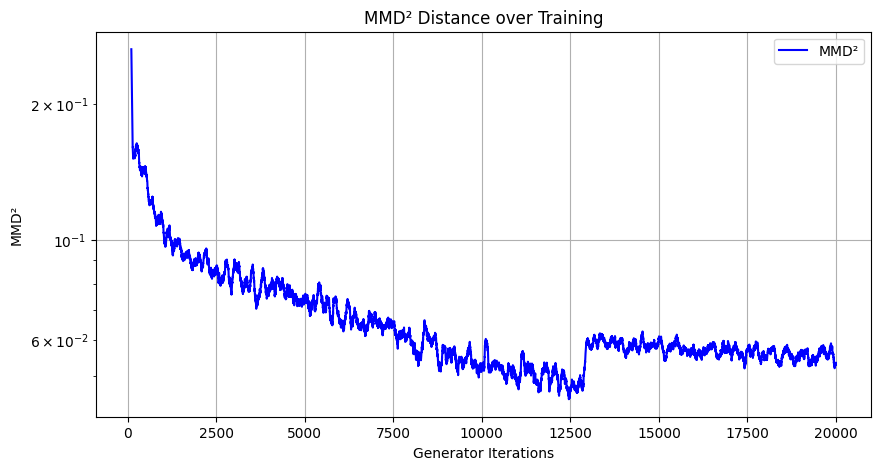

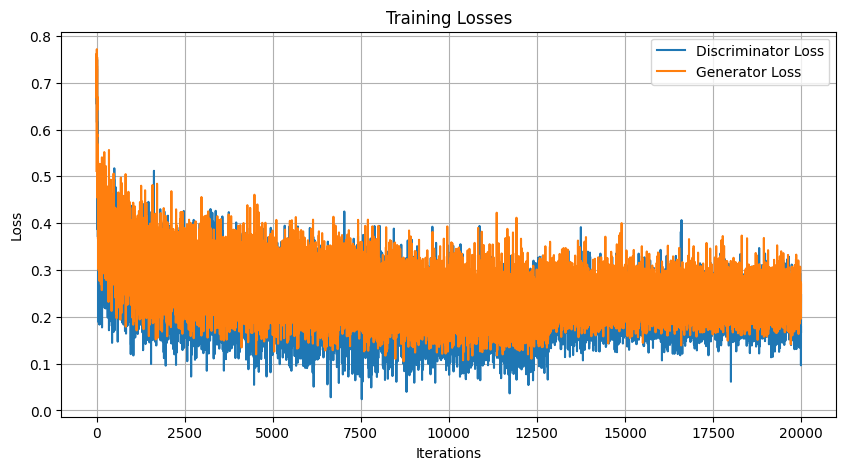

[1062/4000][125/125] Iter: 20000 Loss_D: 0.167976 Loss_G: 0.269019 |gD|: 6.2826e+00 |gG|: 3.7388e+00 Time(min): 12.16


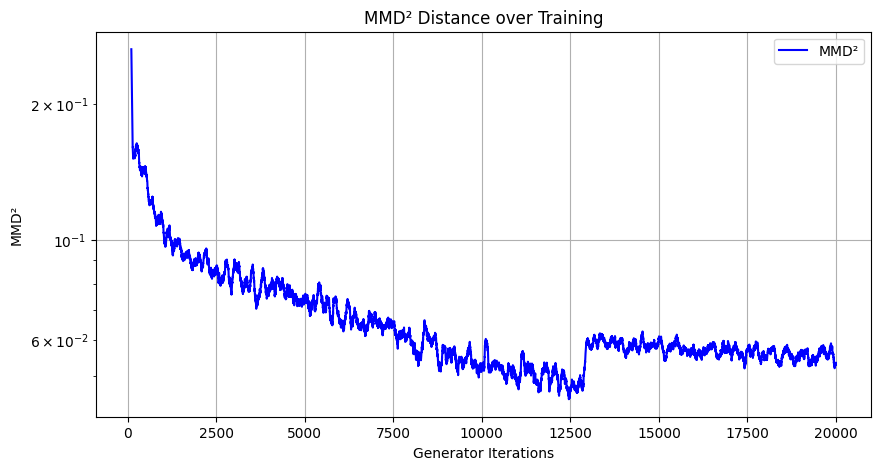

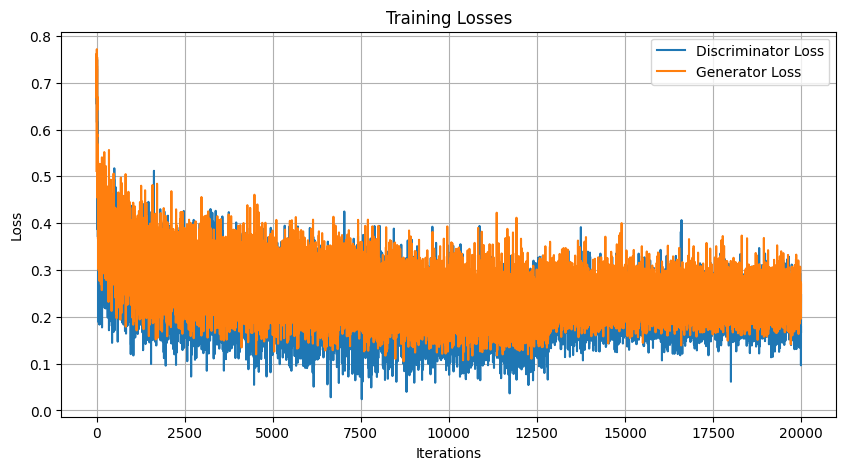

Training Epochs:  27%|██▋       | 1088/4000 [12:28<33:23,  1.45it/s]  

[1088/4000][90/125] Iter: 20500 Loss_D: 0.199426 Loss_G: 0.234352 |gD|: 7.0711e+00 |gG|: 3.3902e+00 Time(min): 12.48


Training Epochs:  27%|██▋       | 1089/4000 [12:28<33:28,  1.45it/s]

[1088/4000][125/125] Iter: 20500 Loss_D: 0.207265 Loss_G: 0.234352 |gD|: 3.6117e+00 |gG|: 3.3902e+00 Time(min): 12.48


Training Epochs:  28%|██▊       | 1114/4000 [12:46<33:04,  1.45it/s]

[1114/4000][90/125] Iter: 21000 Loss_D: 0.201833 Loss_G: 0.229958 |gD|: 2.9318e+00 |gG|: 3.0332e+00 Time(min): 12.78


Training Epochs:  28%|██▊       | 1115/4000 [12:46<33:22,  1.44it/s]

[1114/4000][125/125] Iter: 21000 Loss_D: 0.231762 Loss_G: 0.229958 |gD|: 2.7679e+00 |gG|: 3.0332e+00 Time(min): 12.78


Training Epochs:  29%|██▊       | 1141/4000 [13:05<33:35,  1.42it/s]

[1140/4000][90/125] Iter: 21500 Loss_D: 0.207552 Loss_G: 0.285578 |gD|: 4.0125e+00 |gG|: 2.9327e+00 Time(min): 13.08
[1140/4000][125/125] Iter: 21500 Loss_D: 0.252921 Loss_G: 0.285578 |gD|: 3.7783e+00 |gG|: 2.9327e+00 Time(min): 13.09


Training Epochs:  29%|██▉       | 1166/4000 [13:22<32:54,  1.44it/s]

[1166/4000][90/125] Iter: 22000 Loss_D: 0.224514 Loss_G: 0.204355 |gD|: 1.7658e+00 |gG|: 2.3946e+00 Time(min): 13.38


Training Epochs:  29%|██▉       | 1167/4000 [13:23<33:10,  1.42it/s]

[1166/4000][125/125] Iter: 22000 Loss_D: 0.199705 Loss_G: 0.204355 |gD|: 4.2113e+00 |gG|: 2.3946e+00 Time(min): 13.39


Training Epochs:  30%|██▉       | 1193/4000 [13:41<34:10,  1.37it/s]

[1192/4000][90/125] Iter: 22500 Loss_D: 0.201357 Loss_G: 0.237440 |gD|: 5.1084e+00 |gG|: 4.1424e+00 Time(min): 13.69
[1192/4000][125/125] Iter: 22500 Loss_D: 0.173943 Loss_G: 0.237440 |gD|: 3.4680e+00 |gG|: 4.1424e+00 Time(min): 13.70


Training Epochs:  30%|███       | 1218/4000 [14:00<36:56,  1.26it/s]

[1218/4000][90/125] Iter: 23000 Loss_D: 0.217856 Loss_G: 0.256056 |gD|: 2.6194e+00 |gG|: 2.8463e+00 Time(min): 14.02


Training Epochs:  30%|███       | 1219/4000 [14:01<36:38,  1.26it/s]

[1218/4000][125/125] Iter: 23000 Loss_D: 0.261645 Loss_G: 0.256056 |gD|: 2.4508e+00 |gG|: 2.8463e+00 Time(min): 14.02


Training Epochs:  31%|███       | 1244/4000 [14:20<37:55,  1.21it/s]

[1244/4000][90/125] Iter: 23500 Loss_D: 0.185140 Loss_G: 0.304894 |gD|: 3.5190e+00 |gG|: 3.1973e+00 Time(min): 14.36


Training Epochs:  31%|███       | 1245/4000 [14:21<39:19,  1.17it/s]

[1244/4000][125/125] Iter: 23500 Loss_D: 0.197727 Loss_G: 0.304894 |gD|: 2.9124e+00 |gG|: 3.1973e+00 Time(min): 14.36


Training Epochs:  32%|███▏      | 1271/4000 [14:43<33:16,  1.37it/s]

[1270/4000][90/125] Iter: 24000 Loss_D: 0.253511 Loss_G: 0.275355 |gD|: 5.7577e+00 |gG|: 3.9437e+00 Time(min): 14.71
[1270/4000][125/125] Iter: 24000 Loss_D: 0.164690 Loss_G: 0.275355 |gD|: 4.1580e+00 |gG|: 3.9437e+00 Time(min): 14.72


Training Epochs:  32%|███▏      | 1297/4000 [15:02<30:54,  1.46it/s]

[1296/4000][90/125] Iter: 24500 Loss_D: 0.203974 Loss_G: 0.173469 |gD|: 5.5036e+00 |gG|: 2.5570e+00 Time(min): 15.03
[1296/4000][125/125] Iter: 24500 Loss_D: 0.172688 Loss_G: 0.173469 |gD|: 5.6723e+00 |gG|: 2.5570e+00 Time(min): 15.04


Training Epochs:  33%|███▎      | 1322/4000 [15:20<32:38,  1.37it/s]

[1322/4000][90/125] Iter: 25000 Loss_D: 0.231010 Loss_G: 0.190724 |gD|: 2.5632e+00 |gG|: 2.5946e+00 Time(min): 15.35


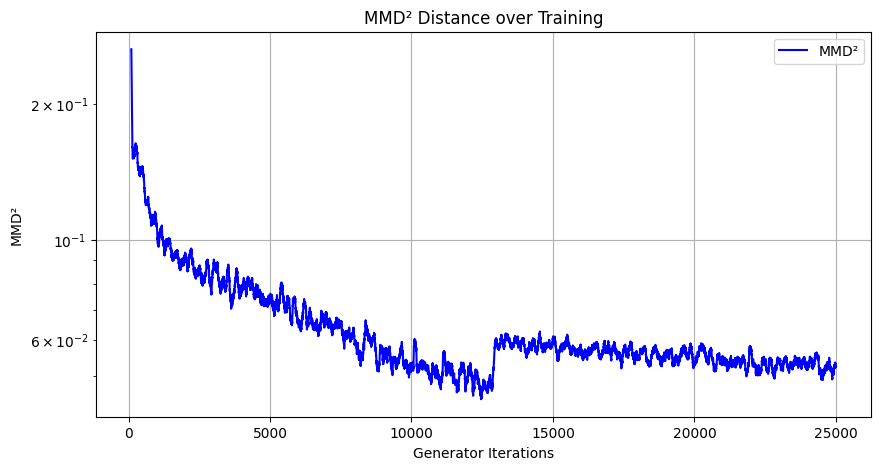

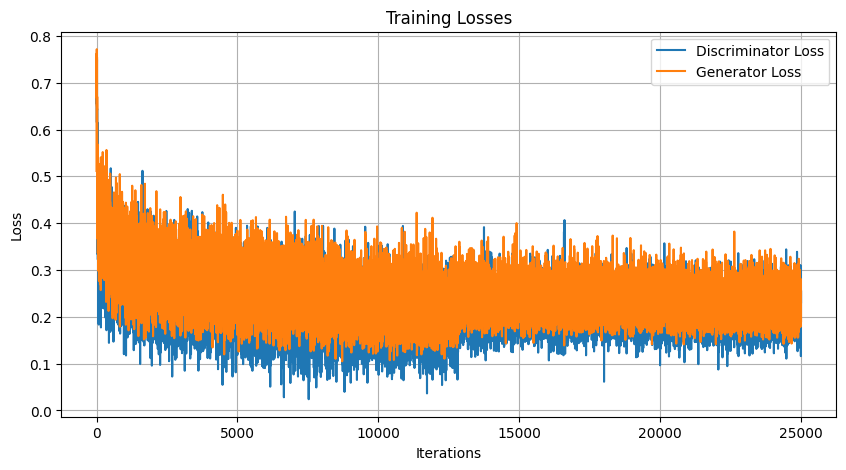

[1322/4000][125/125] Iter: 25000 Loss_D: 0.239489 Loss_G: 0.190724 |gD|: 1.7196e+00 |gG|: 2.5946e+00 Time(min): 15.37


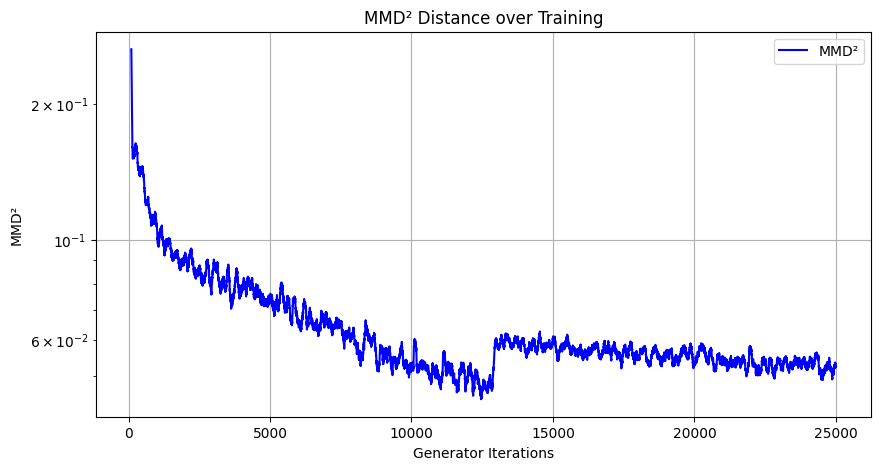

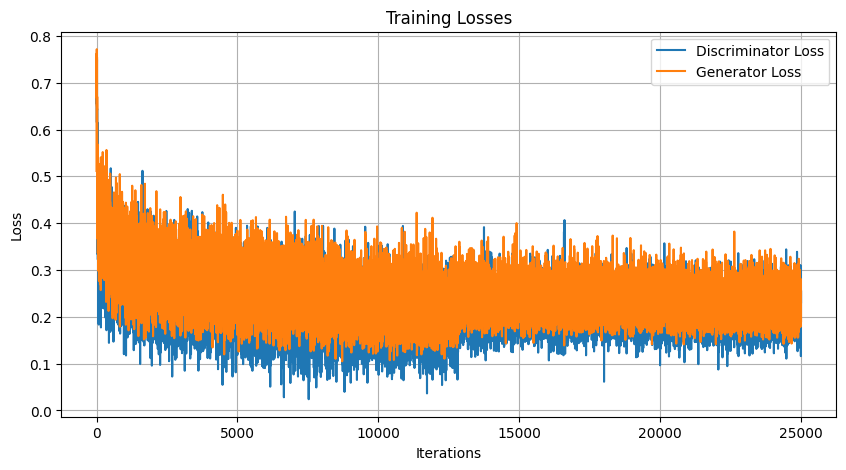

Training Epochs:  34%|███▎      | 1349/4000 [15:43<32:31,  1.36it/s]

[1348/4000][90/125] Iter: 25500 Loss_D: 0.204964 Loss_G: 0.247853 |gD|: 4.5769e+00 |gG|: 3.5222e+00 Time(min): 15.72
[1348/4000][125/125] Iter: 25500 Loss_D: 0.259945 Loss_G: 0.247853 |gD|: 3.0292e+00 |gG|: 3.5222e+00 Time(min): 15.72


Training Epochs:  34%|███▍      | 1374/4000 [16:00<29:56,  1.46it/s]

[1374/4000][90/125] Iter: 26000 Loss_D: 0.239314 Loss_G: 0.272760 |gD|: 2.6648e+00 |gG|: 3.1476e+00 Time(min): 16.02


Training Epochs:  34%|███▍      | 1375/4000 [16:01<30:36,  1.43it/s]

[1374/4000][125/125] Iter: 26000 Loss_D: 0.269139 Loss_G: 0.272760 |gD|: 3.7957e+00 |gG|: 3.1476e+00 Time(min): 16.02


Training Epochs:  35%|███▌      | 1401/4000 [16:20<31:11,  1.39it/s]

[1400/4000][90/125] Iter: 26500 Loss_D: 0.184495 Loss_G: 0.257952 |gD|: 2.1267e+00 |gG|: 4.2340e+00 Time(min): 16.33
[1400/4000][125/125] Iter: 26500 Loss_D: 0.228783 Loss_G: 0.257952 |gD|: 2.6708e+00 |gG|: 4.2340e+00 Time(min): 16.34


Training Epochs:  36%|███▌      | 1426/4000 [16:38<34:40,  1.24it/s]

[1426/4000][90/125] Iter: 27000 Loss_D: 0.185220 Loss_G: 0.290532 |gD|: 3.4034e+00 |gG|: 2.5623e+00 Time(min): 16.66


Training Epochs:  36%|███▌      | 1427/4000 [16:39<34:20,  1.25it/s]

[1426/4000][125/125] Iter: 27000 Loss_D: 0.169909 Loss_G: 0.290532 |gD|: 3.2499e+00 |gG|: 2.5623e+00 Time(min): 16.66


Training Epochs:  36%|███▋      | 1453/4000 [16:58<30:01,  1.41it/s]

[1452/4000][90/125] Iter: 27500 Loss_D: 0.295398 Loss_G: 0.271617 |gD|: 4.3261e+00 |gG|: 3.7430e+00 Time(min): 16.97
[1452/4000][125/125] Iter: 27500 Loss_D: 0.237423 Loss_G: 0.271617 |gD|: 5.9411e+00 |gG|: 3.7430e+00 Time(min): 16.98


Training Epochs:  37%|███▋      | 1478/4000 [17:16<33:28,  1.26it/s]

[1478/4000][90/125] Iter: 28000 Loss_D: 0.174021 Loss_G: 0.257454 |gD|: 5.7855e+00 |gG|: 3.2555e+00 Time(min): 17.29


Training Epochs:  37%|███▋      | 1479/4000 [17:17<33:47,  1.24it/s]

[1478/4000][125/125] Iter: 28000 Loss_D: 0.171115 Loss_G: 0.257454 |gD|: 2.3267e+00 |gG|: 3.2555e+00 Time(min): 17.29


Training Epochs:  38%|███▊      | 1504/4000 [17:35<31:15,  1.33it/s]

[1504/4000][90/125] Iter: 28500 Loss_D: 0.249822 Loss_G: 0.197323 |gD|: 4.8003e+00 |gG|: 3.1376e+00 Time(min): 17.60


Training Epochs:  38%|███▊      | 1505/4000 [17:36<31:42,  1.31it/s]

[1504/4000][125/125] Iter: 28500 Loss_D: 0.188006 Loss_G: 0.197323 |gD|: 2.2499e+00 |gG|: 3.1376e+00 Time(min): 17.61


Training Epochs:  38%|███▊      | 1530/4000 [17:54<30:34,  1.35it/s]

[1530/4000][90/125] Iter: 29000 Loss_D: 0.185676 Loss_G: 0.261618 |gD|: 3.8179e+00 |gG|: 2.4781e+00 Time(min): 17.92


Training Epochs:  38%|███▊      | 1531/4000 [17:55<31:04,  1.32it/s]

[1530/4000][125/125] Iter: 29000 Loss_D: 0.258382 Loss_G: 0.261618 |gD|: 6.1298e+00 |gG|: 2.4781e+00 Time(min): 17.92


Training Epochs:  39%|███▉      | 1556/4000 [18:13<29:41,  1.37it/s]

[1556/4000][90/125] Iter: 29500 Loss_D: 0.247328 Loss_G: 0.251764 |gD|: 2.9787e+00 |gG|: 3.5218e+00 Time(min): 18.23


Training Epochs:  39%|███▉      | 1557/4000 [18:14<29:16,  1.39it/s]

[1556/4000][125/125] Iter: 29500 Loss_D: 0.243111 Loss_G: 0.251764 |gD|: 2.9321e+00 |gG|: 3.5218e+00 Time(min): 18.24


Training Epochs:  40%|███▉      | 1582/4000 [18:32<29:49,  1.35it/s]

[1582/4000][90/125] Iter: 30000 Loss_D: 0.182912 Loss_G: 0.206915 |gD|: 2.9682e+00 |gG|: 3.6259e+00 Time(min): 18.55


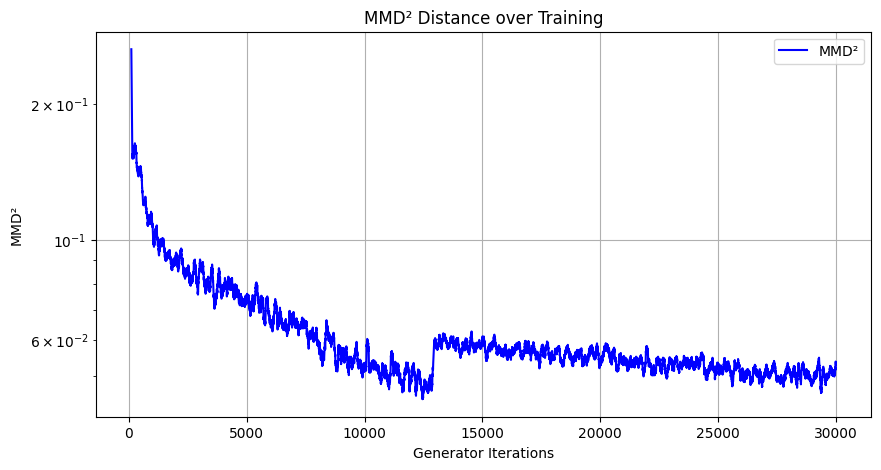

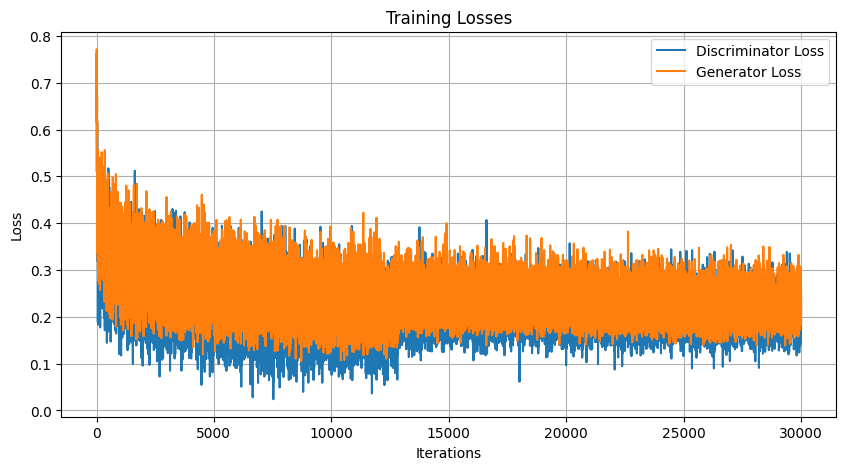

[1582/4000][125/125] Iter: 30000 Loss_D: 0.166770 Loss_G: 0.206915 |gD|: 2.8006e+00 |gG|: 3.6259e+00 Time(min): 18.57


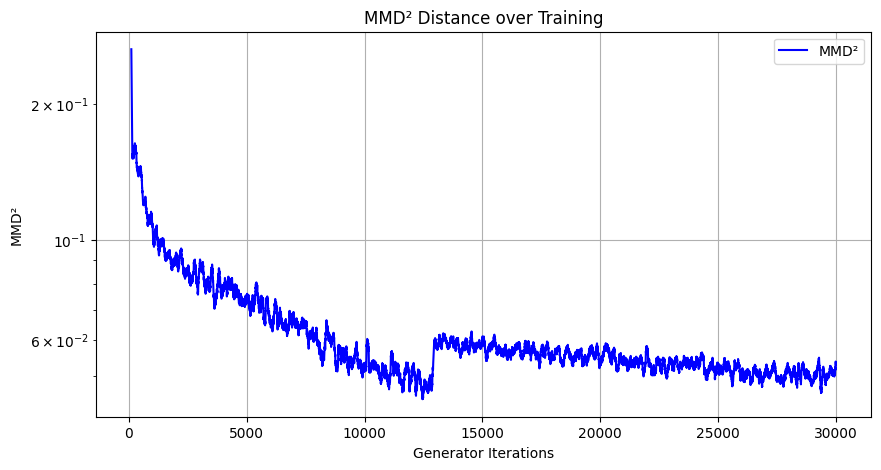

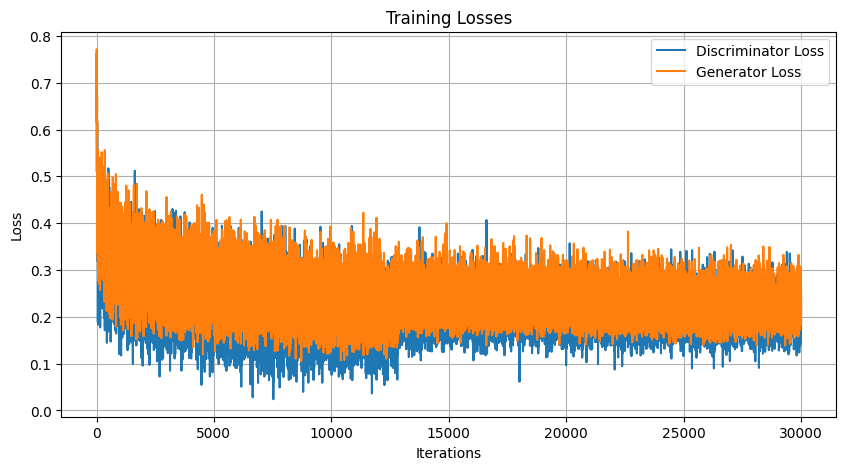

Training Epochs:  40%|████      | 1609/4000 [18:54<28:37,  1.39it/s]

[1608/4000][90/125] Iter: 30500 Loss_D: 0.195099 Loss_G: 0.208087 |gD|: 2.1514e+00 |gG|: 2.8176e+00 Time(min): 18.90
[1608/4000][125/125] Iter: 30500 Loss_D: 0.240653 Loss_G: 0.208087 |gD|: 3.3713e+00 |gG|: 2.8176e+00 Time(min): 18.91


Training Epochs:  41%|████      | 1634/4000 [19:12<29:06,  1.35it/s]

[1634/4000][90/125] Iter: 31000 Loss_D: 0.168451 Loss_G: 0.188320 |gD|: 2.3658e+00 |gG|: 3.5370e+00 Time(min): 19.21


Training Epochs:  41%|████      | 1635/4000 [19:13<29:04,  1.36it/s]

[1634/4000][125/125] Iter: 31000 Loss_D: 0.205506 Loss_G: 0.188320 |gD|: 3.7716e+00 |gG|: 3.5370e+00 Time(min): 19.22


Training Epochs:  42%|████▏     | 1661/4000 [19:31<29:11,  1.34it/s]

[1660/4000][90/125] Iter: 31500 Loss_D: 0.206983 Loss_G: 0.236661 |gD|: 4.5521e+00 |gG|: 4.5632e+00 Time(min): 19.52
[1660/4000][125/125] Iter: 31500 Loss_D: 0.185666 Loss_G: 0.236661 |gD|: 4.3035e+00 |gG|: 4.5632e+00 Time(min): 19.53


Training Epochs:  42%|████▏     | 1686/4000 [19:49<26:51,  1.44it/s]

[1686/4000][90/125] Iter: 32000 Loss_D: 0.215560 Loss_G: 0.215053 |gD|: 2.6831e+00 |gG|: 3.7308e+00 Time(min): 19.83


Training Epochs:  42%|████▏     | 1687/4000 [19:49<27:22,  1.41it/s]

[1686/4000][125/125] Iter: 32000 Loss_D: 0.255792 Loss_G: 0.215053 |gD|: 2.7330e+00 |gG|: 3.7308e+00 Time(min): 19.83


Training Epochs:  43%|████▎     | 1712/4000 [20:08<28:41,  1.33it/s]

[1712/4000][90/125] Iter: 32500 Loss_D: 0.259219 Loss_G: 0.246221 |gD|: 4.6395e+00 |gG|: 3.2272e+00 Time(min): 20.15


Training Epochs:  43%|████▎     | 1713/4000 [20:09<29:13,  1.30it/s]

[1712/4000][125/125] Iter: 32500 Loss_D: 0.212441 Loss_G: 0.246221 |gD|: 3.2010e+00 |gG|: 3.2272e+00 Time(min): 20.15


Training Epochs:  43%|████▎     | 1738/4000 [20:28<27:43,  1.36it/s]

[1738/4000][90/125] Iter: 33000 Loss_D: 0.209460 Loss_G: 0.204714 |gD|: 2.8961e+00 |gG|: 3.8825e+00 Time(min): 20.48


Training Epochs:  43%|████▎     | 1739/4000 [20:28<28:18,  1.33it/s]

[1738/4000][125/125] Iter: 33000 Loss_D: 0.224750 Loss_G: 0.204714 |gD|: 4.4693e+00 |gG|: 3.8825e+00 Time(min): 20.48


Training Epochs:  44%|████▍     | 1765/4000 [20:47<25:59,  1.43it/s]

[1764/4000][90/125] Iter: 33500 Loss_D: 0.336337 Loss_G: 0.197965 |gD|: 4.5876e+00 |gG|: 4.1212e+00 Time(min): 20.79
[1764/4000][125/125] Iter: 33500 Loss_D: 0.167224 Loss_G: 0.197965 |gD|: 2.0895e+00 |gG|: 4.1212e+00 Time(min): 20.80


Training Epochs:  45%|████▍     | 1791/4000 [21:06<25:27,  1.45it/s]

[1790/4000][90/125] Iter: 34000 Loss_D: 0.176558 Loss_G: 0.261362 |gD|: 3.0710e+00 |gG|: 4.4727e+00 Time(min): 21.10
[1790/4000][125/125] Iter: 34000 Loss_D: 0.203397 Loss_G: 0.261362 |gD|: 2.2746e+00 |gG|: 4.4727e+00 Time(min): 21.10


Training Epochs:  45%|████▌     | 1817/4000 [21:25<26:11,  1.39it/s]

[1816/4000][90/125] Iter: 34500 Loss_D: 0.174962 Loss_G: 0.269099 |gD|: 1.4924e+00 |gG|: 3.1163e+00 Time(min): 21.42
[1816/4000][125/125] Iter: 34500 Loss_D: 0.186117 Loss_G: 0.269099 |gD|: 3.7850e+00 |gG|: 3.1163e+00 Time(min): 21.42


Training Epochs:  46%|████▌     | 1842/4000 [21:43<26:03,  1.38it/s]

[1842/4000][90/125] Iter: 35000 Loss_D: 0.180172 Loss_G: 0.194151 |gD|: 1.2400e+00 |gG|: 3.5324e+00 Time(min): 21.74


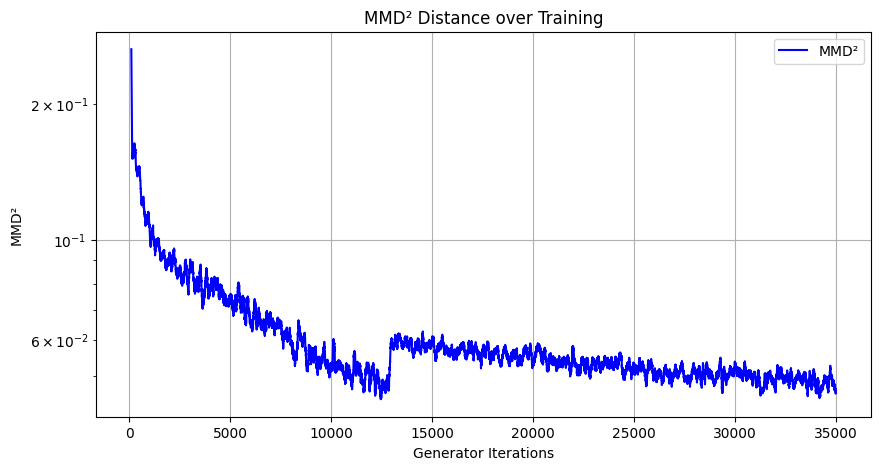

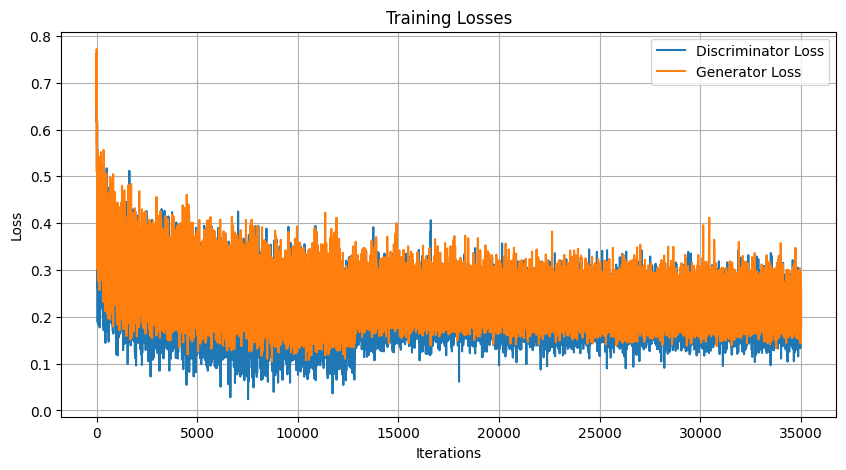

[1842/4000][125/125] Iter: 35000 Loss_D: 0.178843 Loss_G: 0.194151 |gD|: 4.5074e+00 |gG|: 3.5324e+00 Time(min): 21.76


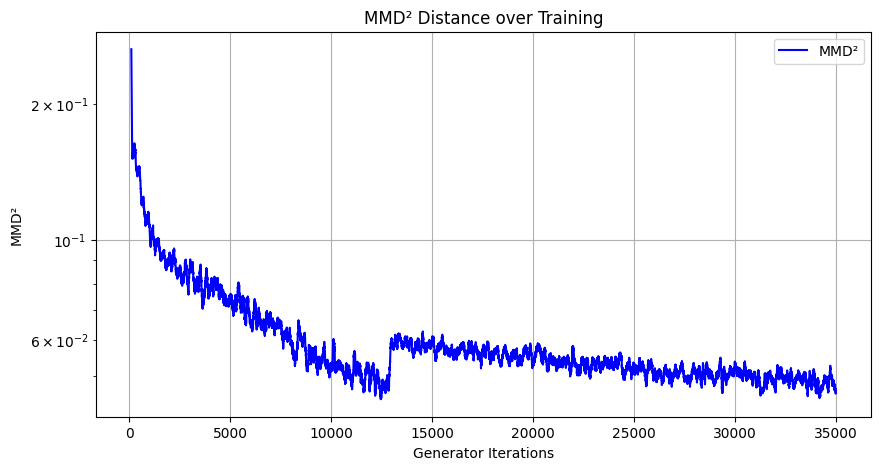

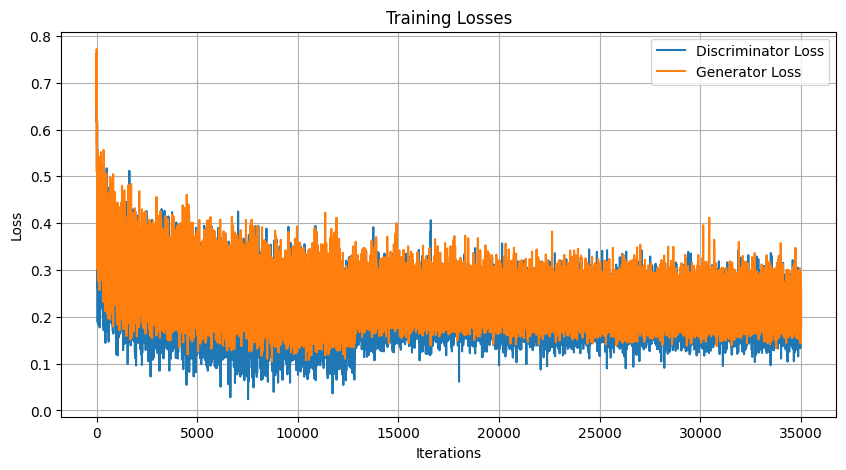

Training Epochs:  47%|████▋     | 1869/4000 [22:05<24:41,  1.44it/s]

[1868/4000][90/125] Iter: 35500 Loss_D: 0.202328 Loss_G: 0.209879 |gD|: 3.2673e+00 |gG|: 3.3221e+00 Time(min): 22.09
[1868/4000][125/125] Iter: 35500 Loss_D: 0.190333 Loss_G: 0.209879 |gD|: 2.2625e+00 |gG|: 3.3221e+00 Time(min): 22.09


Training Epochs:  47%|████▋     | 1894/4000 [22:22<23:36,  1.49it/s]

[1894/4000][90/125] Iter: 36000 Loss_D: 0.206569 Loss_G: 0.240810 |gD|: 3.7959e+00 |gG|: 2.8254e+00 Time(min): 22.38


Training Epochs:  47%|████▋     | 1895/4000 [22:22<23:53,  1.47it/s]

[1894/4000][125/125] Iter: 36000 Loss_D: 0.199473 Loss_G: 0.240810 |gD|: 1.8666e+00 |gG|: 2.8254e+00 Time(min): 22.38


Training Epochs:  48%|████▊     | 1920/4000 [22:41<24:58,  1.39it/s]

[1920/4000][90/125] Iter: 36500 Loss_D: 0.241943 Loss_G: 0.265303 |gD|: 5.5070e+00 |gG|: 2.4517e+00 Time(min): 22.69


Training Epochs:  48%|████▊     | 1921/4000 [22:41<24:49,  1.40it/s]

[1920/4000][125/125] Iter: 36500 Loss_D: 0.235881 Loss_G: 0.265303 |gD|: 2.1493e+00 |gG|: 2.4517e+00 Time(min): 22.70


Training Epochs:  49%|████▊     | 1946/4000 [23:00<26:25,  1.30it/s]

[1946/4000][90/125] Iter: 37000 Loss_D: 0.188026 Loss_G: 0.186347 |gD|: 3.0824e+00 |gG|: 2.5092e+00 Time(min): 23.01


Training Epochs:  49%|████▊     | 1947/4000 [23:00<26:18,  1.30it/s]

[1946/4000][125/125] Iter: 37000 Loss_D: 0.158432 Loss_G: 0.186347 |gD|: 4.2458e+00 |gG|: 2.5092e+00 Time(min): 23.01


Training Epochs:  49%|████▉     | 1972/4000 [23:19<24:36,  1.37it/s]

[1972/4000][90/125] Iter: 37500 Loss_D: 0.208796 Loss_G: 0.184134 |gD|: 1.9028e+00 |gG|: 3.1406e+00 Time(min): 23.33


Training Epochs:  49%|████▉     | 1973/4000 [23:20<24:34,  1.37it/s]

[1972/4000][125/125] Iter: 37500 Loss_D: 0.237804 Loss_G: 0.184134 |gD|: 3.1749e+00 |gG|: 3.1406e+00 Time(min): 23.34


Training Epochs:  50%|████▉     | 1999/4000 [23:38<24:19,  1.37it/s]

[1998/4000][90/125] Iter: 38000 Loss_D: 0.178169 Loss_G: 0.185706 |gD|: 3.1182e+00 |gG|: 2.7378e+00 Time(min): 23.64
[1998/4000][125/125] Iter: 38000 Loss_D: 0.232964 Loss_G: 0.185706 |gD|: 2.2207e+00 |gG|: 2.7378e+00 Time(min): 23.65


Training Epochs:  51%|█████     | 2025/4000 [23:57<23:00,  1.43it/s]

[2024/4000][90/125] Iter: 38500 Loss_D: 0.211048 Loss_G: 0.212988 |gD|: 1.5841e+00 |gG|: 3.1154e+00 Time(min): 23.95
[2024/4000][125/125] Iter: 38500 Loss_D: 0.192982 Loss_G: 0.212988 |gD|: 2.5831e+00 |gG|: 3.1154e+00 Time(min): 23.95


Training Epochs:  51%|█████▏    | 2050/4000 [24:15<25:05,  1.29it/s]

[2050/4000][90/125] Iter: 39000 Loss_D: 0.227406 Loss_G: 0.203776 |gD|: 2.0156e+00 |gG|: 2.5819e+00 Time(min): 24.26


Training Epochs:  51%|█████▏    | 2051/4000 [24:15<25:39,  1.27it/s]

[2050/4000][125/125] Iter: 39000 Loss_D: 0.183923 Loss_G: 0.203776 |gD|: 1.4878e+00 |gG|: 2.5819e+00 Time(min): 24.27


Training Epochs:  52%|█████▏    | 2077/4000 [24:34<21:48,  1.47it/s]

[2076/4000][90/125] Iter: 39500 Loss_D: 0.206507 Loss_G: 0.179231 |gD|: 4.2006e+00 |gG|: 3.0164e+00 Time(min): 24.58
[2076/4000][125/125] Iter: 39500 Loss_D: 0.169579 Loss_G: 0.179231 |gD|: 2.7226e+00 |gG|: 3.0164e+00 Time(min): 24.58


Training Epochs:  53%|█████▎    | 2102/4000 [24:53<22:17,  1.42it/s]

[2102/4000][90/125] Iter: 40000 Loss_D: 0.241990 Loss_G: 0.195847 |gD|: 3.1395e+00 |gG|: 1.6511e+00 Time(min): 24.90


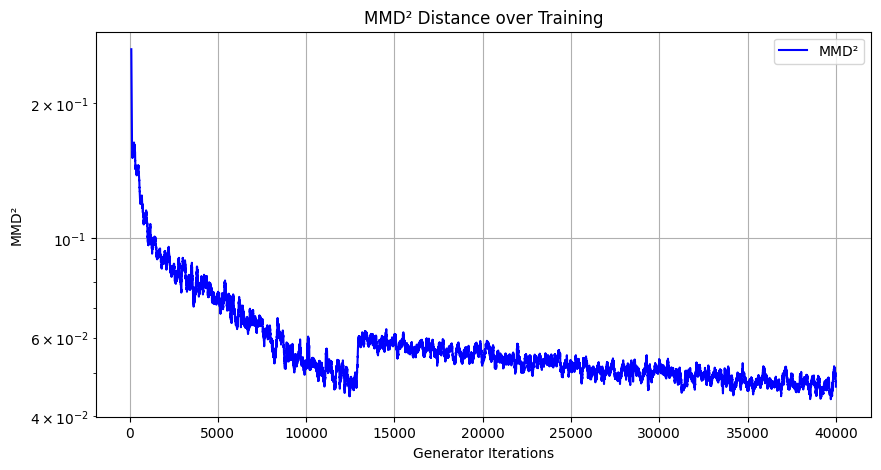

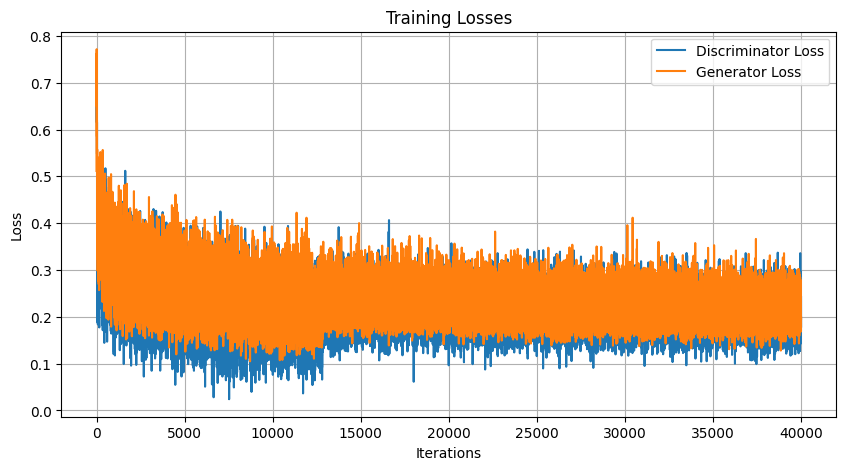

[2102/4000][125/125] Iter: 40000 Loss_D: 0.200801 Loss_G: 0.195847 |gD|: 1.8038e+00 |gG|: 1.6511e+00 Time(min): 24.92


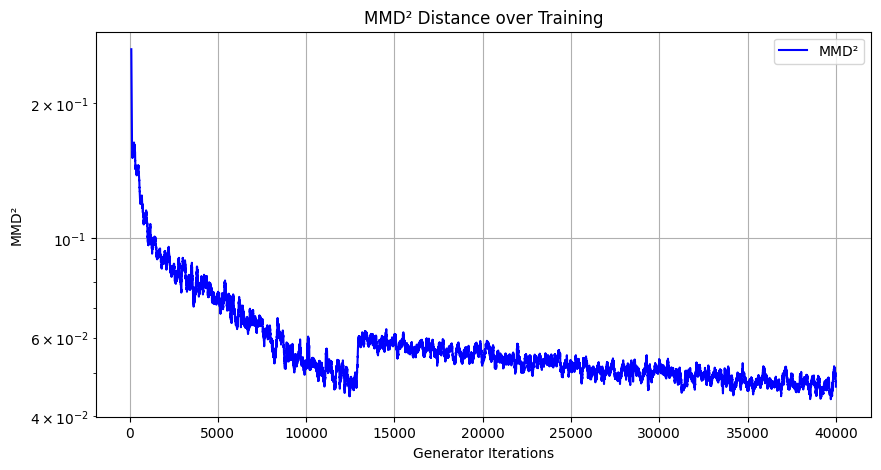

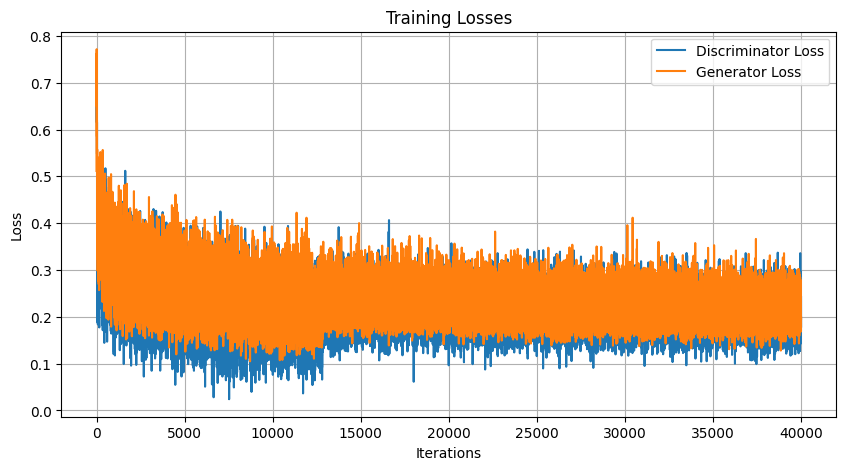

Training Epochs:  53%|█████▎    | 2128/4000 [25:14<21:22,  1.46it/s]

[2128/4000][90/125] Iter: 40500 Loss_D: 0.221153 Loss_G: 0.199433 |gD|: 5.6840e+00 |gG|: 2.8679e+00 Time(min): 25.24


Training Epochs:  53%|█████▎    | 2129/4000 [25:14<21:40,  1.44it/s]

[2128/4000][125/125] Iter: 40500 Loss_D: 0.205185 Loss_G: 0.199433 |gD|: 1.5958e+00 |gG|: 2.8679e+00 Time(min): 25.25


Training Epochs:  54%|█████▍    | 2155/4000 [25:32<20:29,  1.50it/s]

[2154/4000][90/125] Iter: 41000 Loss_D: 0.202114 Loss_G: 0.235447 |gD|: 1.9227e+00 |gG|: 4.2014e+00 Time(min): 25.54
[2154/4000][125/125] Iter: 41000 Loss_D: 0.182324 Loss_G: 0.235447 |gD|: 2.3211e+00 |gG|: 4.2014e+00 Time(min): 25.54


Training Epochs:  55%|█████▍    | 2181/4000 [25:50<20:04,  1.51it/s]

[2180/4000][90/125] Iter: 41500 Loss_D: 0.245291 Loss_G: 0.261150 |gD|: 3.4170e+00 |gG|: 2.7149e+00 Time(min): 25.84
[2180/4000][125/125] Iter: 41500 Loss_D: 0.152230 Loss_G: 0.261150 |gD|: 1.9725e+00 |gG|: 2.7149e+00 Time(min): 25.84


Training Epochs:  55%|█████▌    | 2207/4000 [26:08<20:11,  1.48it/s]

[2206/4000][90/125] Iter: 42000 Loss_D: 0.202820 Loss_G: 0.167871 |gD|: 2.2436e+00 |gG|: 2.7065e+00 Time(min): 26.13
[2206/4000][125/125] Iter: 42000 Loss_D: 0.167525 Loss_G: 0.167871 |gD|: 1.5877e+00 |gG|: 2.7065e+00 Time(min): 26.14


Training Epochs:  56%|█████▌    | 2233/4000 [26:25<19:56,  1.48it/s]

[2232/4000][90/125] Iter: 42500 Loss_D: 0.183662 Loss_G: 0.167506 |gD|: 3.7844e+00 |gG|: 3.0258e+00 Time(min): 26.42
[2232/4000][125/125] Iter: 42500 Loss_D: 0.146415 Loss_G: 0.167506 |gD|: 3.7478e+00 |gG|: 3.0258e+00 Time(min): 26.43


Training Epochs:  56%|█████▋    | 2259/4000 [26:43<20:24,  1.42it/s]

[2258/4000][90/125] Iter: 43000 Loss_D: 0.210934 Loss_G: 0.239657 |gD|: 4.5875e+00 |gG|: 3.1929e+00 Time(min): 26.73
[2258/4000][125/125] Iter: 43000 Loss_D: 0.188430 Loss_G: 0.239657 |gD|: 1.9258e+00 |gG|: 3.1929e+00 Time(min): 26.73


Training Epochs:  57%|█████▋    | 2285/4000 [27:01<19:07,  1.49it/s]

[2284/4000][90/125] Iter: 43500 Loss_D: 0.219986 Loss_G: 0.244607 |gD|: 2.6112e+00 |gG|: 2.6686e+00 Time(min): 27.02
[2284/4000][125/125] Iter: 43500 Loss_D: 0.190764 Loss_G: 0.244607 |gD|: 3.0249e+00 |gG|: 2.6686e+00 Time(min): 27.02


Training Epochs:  58%|█████▊    | 2311/4000 [27:18<18:51,  1.49it/s]

[2310/4000][90/125] Iter: 44000 Loss_D: 0.198989 Loss_G: 0.196326 |gD|: 2.2060e+00 |gG|: 3.2652e+00 Time(min): 27.31
[2310/4000][125/125] Iter: 44000 Loss_D: 0.182772 Loss_G: 0.196326 |gD|: 2.4313e+00 |gG|: 3.2652e+00 Time(min): 27.31


Training Epochs:  58%|█████▊    | 2336/4000 [27:40<35:33,  1.28s/it]

[2336/4000][90/125] Iter: 44500 Loss_D: 0.189589 Loss_G: 0.178894 |gD|: 3.4642e+00 |gG|: 2.2668e+00 Time(min): 27.69


Training Epochs:  58%|█████▊    | 2337/4000 [27:41<31:01,  1.12s/it]

[2336/4000][125/125] Iter: 44500 Loss_D: 0.148777 Loss_G: 0.178894 |gD|: 5.8140e+00 |gG|: 2.2668e+00 Time(min): 27.69


Training Epochs:  59%|█████▉    | 2362/4000 [27:58<18:10,  1.50it/s]

[2362/4000][90/125] Iter: 45000 Loss_D: 0.283930 Loss_G: 0.218999 |gD|: 3.4283e+00 |gG|: 3.0211e+00 Time(min): 27.98


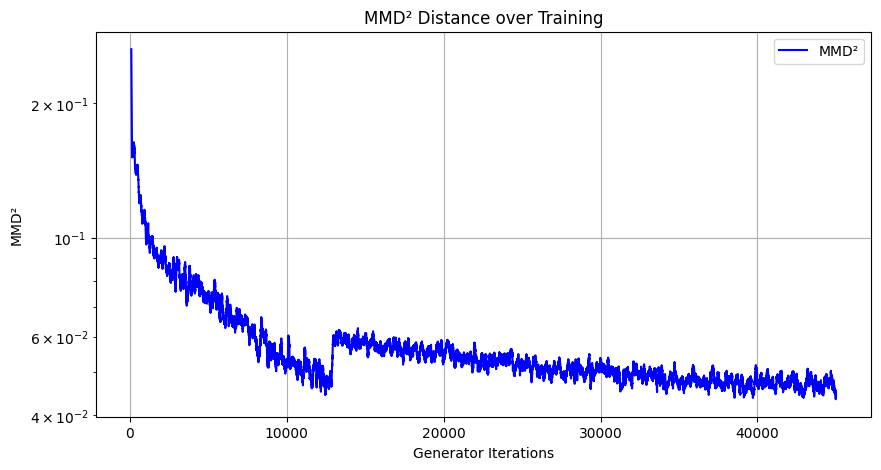

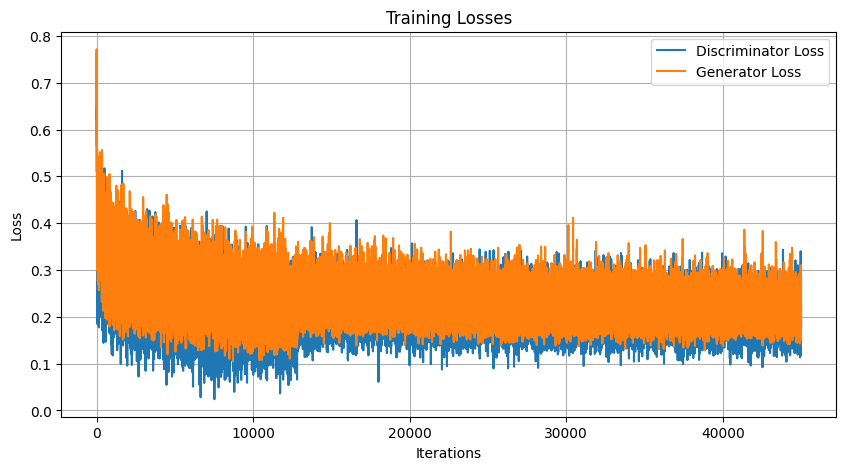

[2362/4000][125/125] Iter: 45000 Loss_D: 0.219309 Loss_G: 0.218999 |gD|: 1.7127e+00 |gG|: 3.0211e+00 Time(min): 28.00


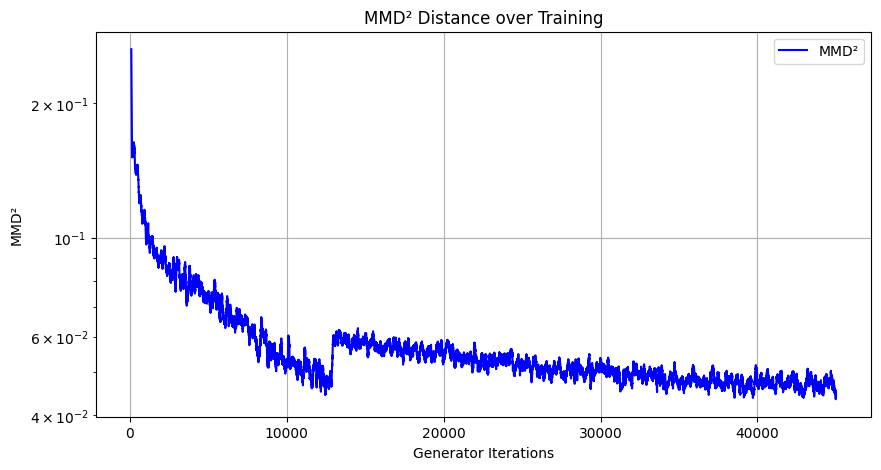

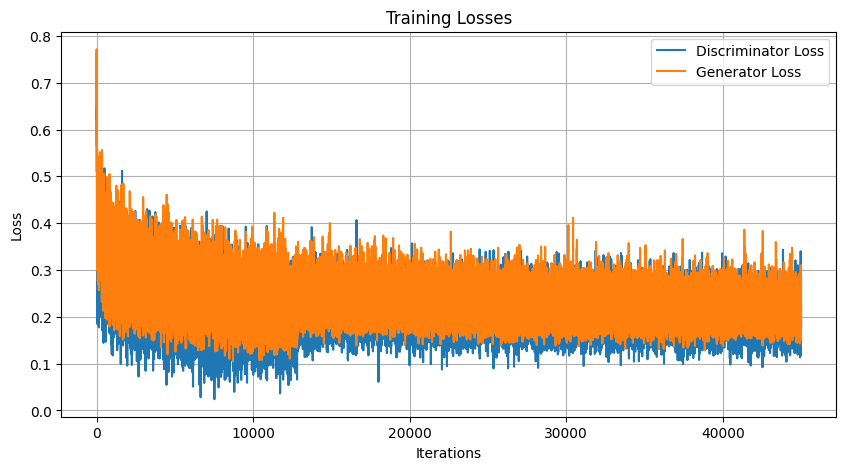

Training Epochs:  60%|█████▉    | 2389/4000 [28:19<18:13,  1.47it/s]

[2388/4000][90/125] Iter: 45500 Loss_D: 0.209948 Loss_G: 0.257661 |gD|: 2.0420e+00 |gG|: 4.3079e+00 Time(min): 28.31
[2388/4000][125/125] Iter: 45500 Loss_D: 0.163323 Loss_G: 0.257661 |gD|: 4.8191e+00 |gG|: 4.3079e+00 Time(min): 28.32


Training Epochs:  60%|██████    | 2415/4000 [28:36<17:56,  1.47it/s]

[2414/4000][90/125] Iter: 46000 Loss_D: 0.179866 Loss_G: 0.210994 |gD|: 2.6683e+00 |gG|: 3.3192e+00 Time(min): 28.61
[2414/4000][125/125] Iter: 46000 Loss_D: 0.222780 Loss_G: 0.210994 |gD|: 4.5731e+00 |gG|: 3.3192e+00 Time(min): 28.61


Training Epochs:  61%|██████    | 2441/4000 [28:54<17:29,  1.49it/s]

[2440/4000][90/125] Iter: 46500 Loss_D: 0.173130 Loss_G: 0.214171 |gD|: 3.3414e+00 |gG|: 2.2346e+00 Time(min): 28.90
[2440/4000][125/125] Iter: 46500 Loss_D: 0.197906 Loss_G: 0.214171 |gD|: 2.5510e+00 |gG|: 2.2346e+00 Time(min): 28.91


Training Epochs:  62%|██████▏   | 2467/4000 [29:12<17:08,  1.49it/s]

[2466/4000][90/125] Iter: 47000 Loss_D: 0.154314 Loss_G: 0.210918 |gD|: 2.0378e+00 |gG|: 2.7930e+00 Time(min): 29.20
[2466/4000][125/125] Iter: 47000 Loss_D: 0.260757 Loss_G: 0.210918 |gD|: 3.3209e+00 |gG|: 2.7930e+00 Time(min): 29.20


Training Epochs:  62%|██████▏   | 2493/4000 [29:29<16:46,  1.50it/s]

[2492/4000][90/125] Iter: 47500 Loss_D: 0.188739 Loss_G: 0.184389 |gD|: 2.7809e+00 |gG|: 2.0815e+00 Time(min): 29.49
[2492/4000][125/125] Iter: 47500 Loss_D: 0.184441 Loss_G: 0.184389 |gD|: 4.0733e+00 |gG|: 2.0815e+00 Time(min): 29.50


Training Epochs:  63%|██████▎   | 2519/4000 [29:46<15:59,  1.54it/s]

[2518/4000][90/125] Iter: 48000 Loss_D: 0.194714 Loss_G: 0.205967 |gD|: 2.1991e+00 |gG|: 3.3082e+00 Time(min): 29.78
[2518/4000][125/125] Iter: 48000 Loss_D: 0.147713 Loss_G: 0.205967 |gD|: 5.5410e+00 |gG|: 3.3082e+00 Time(min): 29.78


Training Epochs:  64%|██████▎   | 2545/4000 [30:04<16:08,  1.50it/s]

[2544/4000][90/125] Iter: 48500 Loss_D: 0.273926 Loss_G: 0.201209 |gD|: 1.9316e+00 |gG|: 2.9490e+00 Time(min): 30.07
[2544/4000][125/125] Iter: 48500 Loss_D: 0.210031 Loss_G: 0.201209 |gD|: 4.5202e+00 |gG|: 2.9490e+00 Time(min): 30.08


Training Epochs:  64%|██████▍   | 2571/4000 [30:22<17:06,  1.39it/s]

[2570/4000][90/125] Iter: 49000 Loss_D: 0.169367 Loss_G: 0.220035 |gD|: 3.5360e+00 |gG|: 2.4324e+00 Time(min): 30.37
[2570/4000][125/125] Iter: 49000 Loss_D: 0.159502 Loss_G: 0.220035 |gD|: 2.0111e+00 |gG|: 2.4324e+00 Time(min): 30.38


Training Epochs:  65%|██████▍   | 2597/4000 [30:40<15:45,  1.48it/s]

[2596/4000][90/125] Iter: 49500 Loss_D: 0.201708 Loss_G: 0.184170 |gD|: 1.8422e+00 |gG|: 2.9458e+00 Time(min): 30.67
[2596/4000][125/125] Iter: 49500 Loss_D: 0.185790 Loss_G: 0.184170 |gD|: 1.6004e+00 |gG|: 2.9458e+00 Time(min): 30.67


Training Epochs:  66%|██████▌   | 2622/4000 [30:56<15:14,  1.51it/s]

[2622/4000][90/125] Iter: 50000 Loss_D: 0.170652 Loss_G: 0.206666 |gD|: 4.5318e+00 |gG|: 2.5346e+00 Time(min): 30.96


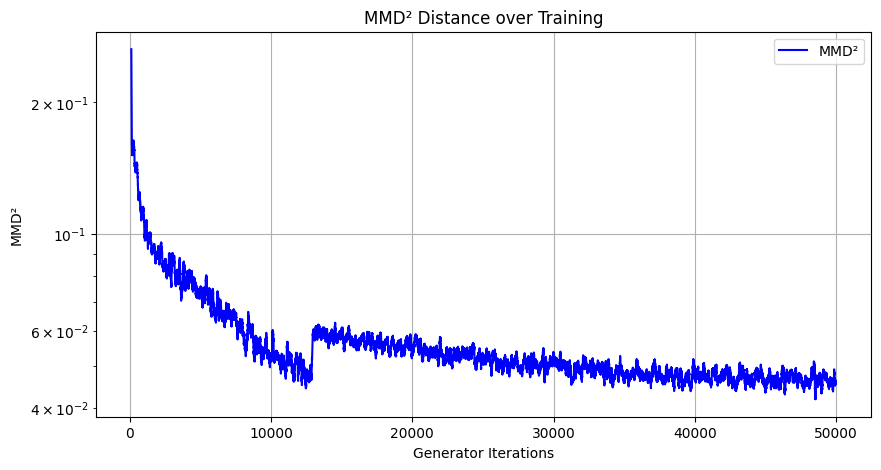

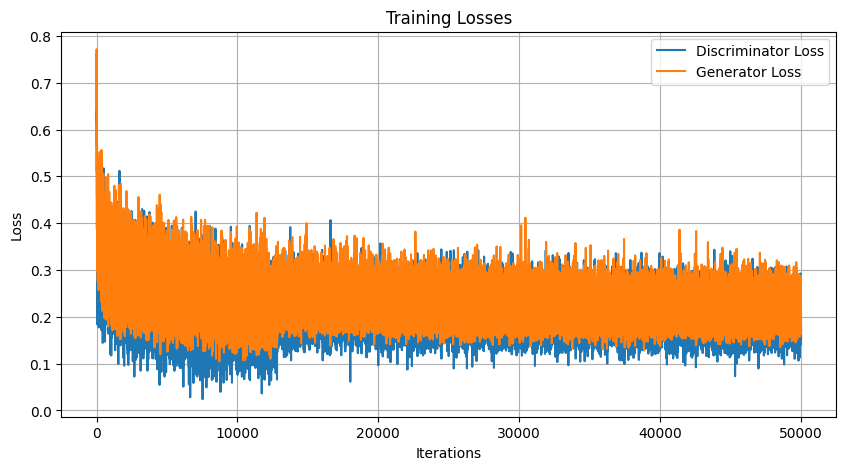

[2622/4000][125/125] Iter: 50000 Loss_D: 0.164253 Loss_G: 0.206666 |gD|: 3.0585e+00 |gG|: 2.5346e+00 Time(min): 30.98


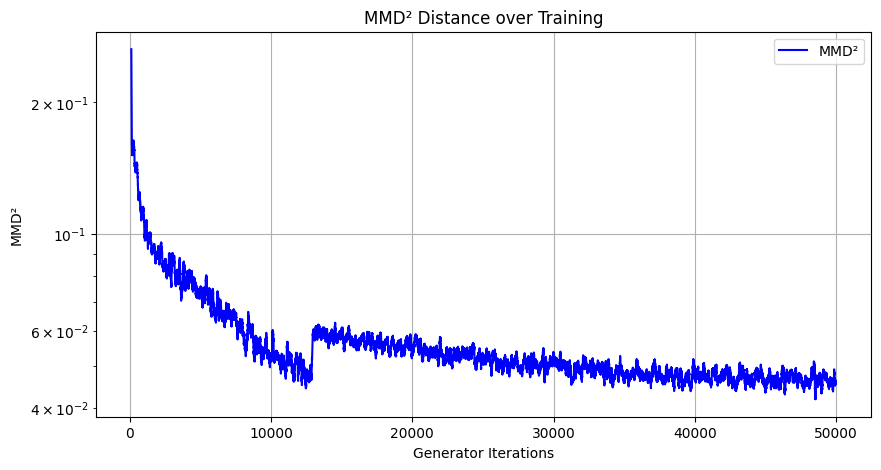

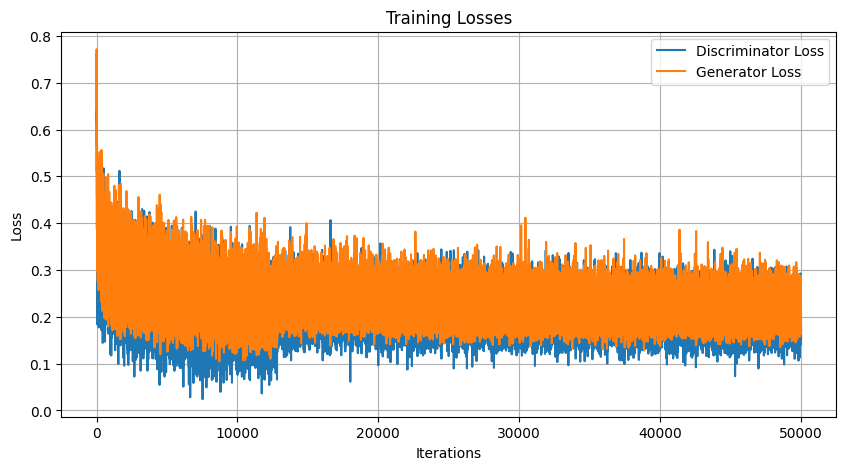

Training Epochs:  66%|██████▌   | 2649/4000 [31:17<15:06,  1.49it/s]

[2648/4000][90/125] Iter: 50500 Loss_D: 0.220217 Loss_G: 0.200072 |gD|: 3.9599e+00 |gG|: 2.9425e+00 Time(min): 31.29
[2648/4000][125/125] Iter: 50500 Loss_D: 0.140938 Loss_G: 0.200072 |gD|: 3.1322e+00 |gG|: 2.9425e+00 Time(min): 31.29


Training Epochs:  67%|██████▋   | 2675/4000 [31:34<14:44,  1.50it/s]

[2674/4000][90/125] Iter: 51000 Loss_D: 0.210715 Loss_G: 0.216238 |gD|: 3.7230e+00 |gG|: 3.4126e+00 Time(min): 31.58
[2674/4000][125/125] Iter: 51000 Loss_D: 0.220686 Loss_G: 0.216238 |gD|: 3.0684e+00 |gG|: 3.4126e+00 Time(min): 31.58


Training Epochs:  68%|██████▊   | 2701/4000 [31:52<14:34,  1.49it/s]

[2700/4000][90/125] Iter: 51500 Loss_D: 0.230144 Loss_G: 0.226634 |gD|: 2.9274e+00 |gG|: 4.4157e+00 Time(min): 31.87
[2700/4000][125/125] Iter: 51500 Loss_D: 0.272972 Loss_G: 0.226634 |gD|: 2.7163e+00 |gG|: 4.4157e+00 Time(min): 31.87


Training Epochs:  68%|██████▊   | 2726/4000 [32:09<14:31,  1.46it/s]

[2726/4000][90/125] Iter: 52000 Loss_D: 0.193587 Loss_G: 0.225434 |gD|: 1.5879e+00 |gG|: 3.3276e+00 Time(min): 32.16


Training Epochs:  68%|██████▊   | 2727/4000 [32:09<14:35,  1.45it/s]

[2726/4000][125/125] Iter: 52000 Loss_D: 0.211249 Loss_G: 0.225434 |gD|: 2.1724e+00 |gG|: 3.3276e+00 Time(min): 32.16


Training Epochs:  69%|██████▉   | 2753/4000 [32:27<13:27,  1.54it/s]

[2752/4000][90/125] Iter: 52500 Loss_D: 0.245592 Loss_G: 0.194516 |gD|: 4.1274e+00 |gG|: 3.1921e+00 Time(min): 32.46
[2752/4000][125/125] Iter: 52500 Loss_D: 0.181051 Loss_G: 0.194516 |gD|: 4.4098e+00 |gG|: 3.1921e+00 Time(min): 32.46


Training Epochs:  69%|██████▉   | 2779/4000 [32:44<13:38,  1.49it/s]

[2778/4000][90/125] Iter: 53000 Loss_D: 0.202223 Loss_G: 0.207733 |gD|: 3.9654e+00 |gG|: 2.9185e+00 Time(min): 32.74
[2778/4000][125/125] Iter: 53000 Loss_D: 0.192764 Loss_G: 0.207733 |gD|: 5.8589e+00 |gG|: 2.9185e+00 Time(min): 32.75


Training Epochs:  70%|███████   | 2805/4000 [33:02<13:18,  1.50it/s]

[2804/4000][90/125] Iter: 53500 Loss_D: 0.177723 Loss_G: 0.251466 |gD|: 3.7841e+00 |gG|: 3.4166e+00 Time(min): 33.04
[2804/4000][125/125] Iter: 53500 Loss_D: 0.223245 Loss_G: 0.251466 |gD|: 2.7245e+00 |gG|: 3.4166e+00 Time(min): 33.04


Training Epochs:  71%|███████   | 2831/4000 [33:20<14:01,  1.39it/s]

[2830/4000][90/125] Iter: 54000 Loss_D: 0.223282 Loss_G: 0.197351 |gD|: 2.0316e+00 |gG|: 2.3001e+00 Time(min): 33.34
[2830/4000][125/125] Iter: 54000 Loss_D: 0.220150 Loss_G: 0.197351 |gD|: 3.7870e+00 |gG|: 2.3001e+00 Time(min): 33.34


Training Epochs:  71%|███████▏  | 2857/4000 [33:38<12:50,  1.48it/s]

[2856/4000][90/125] Iter: 54500 Loss_D: 0.192779 Loss_G: 0.243486 |gD|: 3.3860e+00 |gG|: 4.0099e+00 Time(min): 33.64
[2856/4000][125/125] Iter: 54500 Loss_D: 0.251040 Loss_G: 0.243486 |gD|: 2.2522e+00 |gG|: 4.0099e+00 Time(min): 33.64


Training Epochs:  72%|███████▏  | 2882/4000 [33:55<12:41,  1.47it/s]

[2882/4000][90/125] Iter: 55000 Loss_D: 0.165704 Loss_G: 0.219332 |gD|: 1.8563e+00 |gG|: 3.8519e+00 Time(min): 33.93


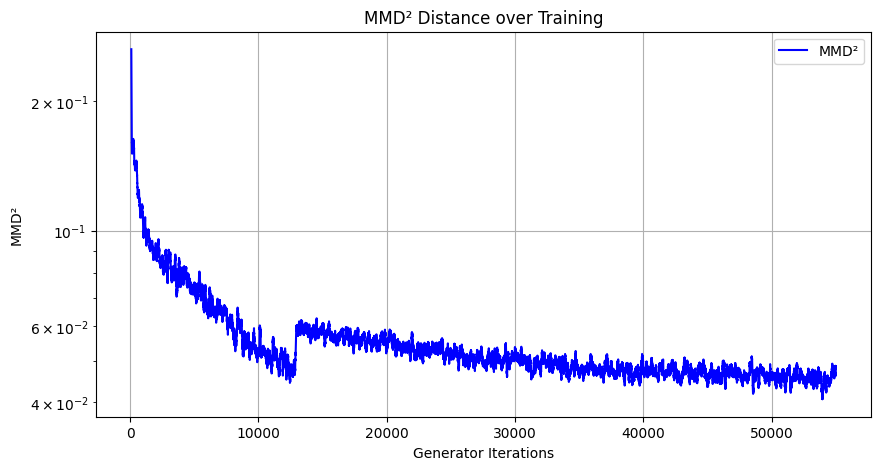

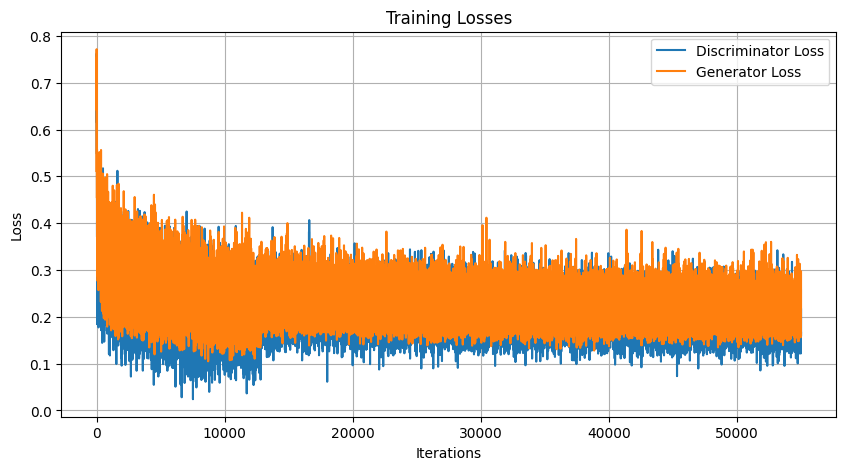

[2882/4000][125/125] Iter: 55000 Loss_D: 0.201483 Loss_G: 0.219332 |gD|: 2.9671e+00 |gG|: 3.8519e+00 Time(min): 33.96


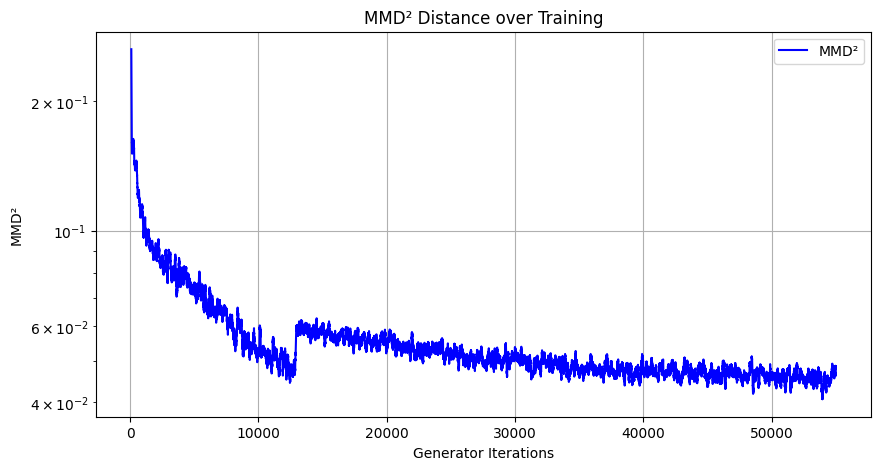

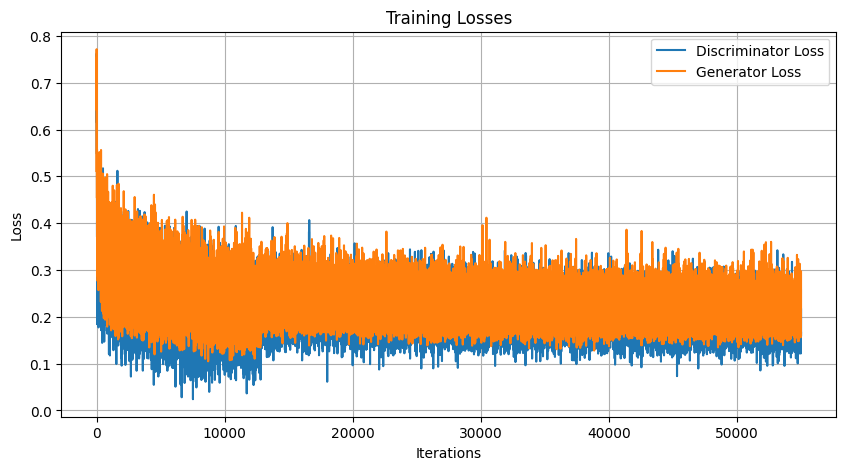

Training Epochs:  73%|███████▎  | 2909/4000 [34:16<12:13,  1.49it/s]

[2908/4000][90/125] Iter: 55500 Loss_D: 0.203728 Loss_G: 0.211187 |gD|: 2.9119e+00 |gG|: 2.3896e+00 Time(min): 34.26
[2908/4000][125/125] Iter: 55500 Loss_D: 0.192110 Loss_G: 0.211187 |gD|: 2.6958e+00 |gG|: 2.3896e+00 Time(min): 34.27


Training Epochs:  73%|███████▎  | 2935/4000 [34:33<11:54,  1.49it/s]

[2934/4000][90/125] Iter: 56000 Loss_D: 0.211131 Loss_G: 0.197005 |gD|: 3.3286e+00 |gG|: 3.8985e+00 Time(min): 34.56
[2934/4000][125/125] Iter: 56000 Loss_D: 0.178990 Loss_G: 0.197005 |gD|: 2.9209e+00 |gG|: 3.8985e+00 Time(min): 34.57


Training Epochs:  74%|███████▍  | 2961/4000 [34:51<11:38,  1.49it/s]

[2960/4000][90/125] Iter: 56500 Loss_D: 0.194080 Loss_G: 0.214511 |gD|: 1.7897e+00 |gG|: 2.4171e+00 Time(min): 34.86
[2960/4000][125/125] Iter: 56500 Loss_D: 0.187271 Loss_G: 0.214511 |gD|: 3.5628e+00 |gG|: 2.4171e+00 Time(min): 34.86


Training Epochs:  75%|███████▍  | 2987/4000 [35:09<11:25,  1.48it/s]

[2986/4000][90/125] Iter: 57000 Loss_D: 0.128678 Loss_G: 0.204740 |gD|: 2.6807e+00 |gG|: 2.2236e+00 Time(min): 35.15
[2986/4000][125/125] Iter: 57000 Loss_D: 0.173324 Loss_G: 0.204740 |gD|: 1.7784e+00 |gG|: 2.2236e+00 Time(min): 35.15


Training Epochs:  75%|███████▌  | 3012/4000 [35:26<11:44,  1.40it/s]

[3012/4000][90/125] Iter: 57500 Loss_D: 0.220075 Loss_G: 0.196465 |gD|: 3.6953e+00 |gG|: 2.4791e+00 Time(min): 35.44


Training Epochs:  75%|███████▌  | 3013/4000 [35:26<11:50,  1.39it/s]

[3012/4000][125/125] Iter: 57500 Loss_D: 0.176800 Loss_G: 0.196465 |gD|: 4.0376e+00 |gG|: 2.4791e+00 Time(min): 35.45


Training Epochs:  76%|███████▌  | 3039/4000 [35:44<10:21,  1.55it/s]

[3038/4000][90/125] Iter: 58000 Loss_D: 0.172571 Loss_G: 0.165516 |gD|: 2.8371e+00 |gG|: 1.9190e+00 Time(min): 35.74
[3038/4000][125/125] Iter: 58000 Loss_D: 0.223397 Loss_G: 0.165516 |gD|: 3.7354e+00 |gG|: 1.9190e+00 Time(min): 35.74


Training Epochs:  77%|███████▋  | 3065/4000 [36:01<10:33,  1.48it/s]

[3064/4000][90/125] Iter: 58500 Loss_D: 0.136124 Loss_G: 0.194239 |gD|: 6.8592e+00 |gG|: 1.6743e+00 Time(min): 36.03
[3064/4000][125/125] Iter: 58500 Loss_D: 0.172518 Loss_G: 0.194239 |gD|: 3.0121e+00 |gG|: 1.6743e+00 Time(min): 36.03


Training Epochs:  77%|███████▋  | 3091/4000 [36:19<10:16,  1.47it/s]

[3090/4000][90/125] Iter: 59000 Loss_D: 0.141044 Loss_G: 0.178562 |gD|: 2.6113e+00 |gG|: 2.6146e+00 Time(min): 36.33
[3090/4000][125/125] Iter: 59000 Loss_D: 0.174196 Loss_G: 0.178562 |gD|: 4.8381e+00 |gG|: 2.6146e+00 Time(min): 36.33


Training Epochs:  78%|███████▊  | 3117/4000 [36:37<09:52,  1.49it/s]

[3116/4000][90/125] Iter: 59500 Loss_D: 0.252420 Loss_G: 0.216469 |gD|: 2.1569e+00 |gG|: 4.4368e+00 Time(min): 36.62
[3116/4000][125/125] Iter: 59500 Loss_D: 0.195989 Loss_G: 0.216469 |gD|: 2.0118e+00 |gG|: 4.4368e+00 Time(min): 36.62


Training Epochs:  79%|███████▊  | 3142/4000 [36:53<09:27,  1.51it/s]

[3142/4000][90/125] Iter: 60000 Loss_D: 0.196256 Loss_G: 0.250022 |gD|: 1.5406e+00 |gG|: 3.6532e+00 Time(min): 36.91


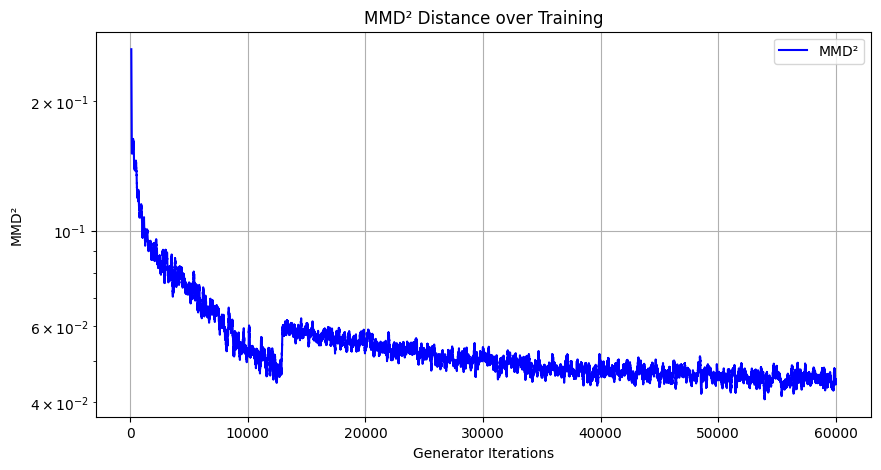

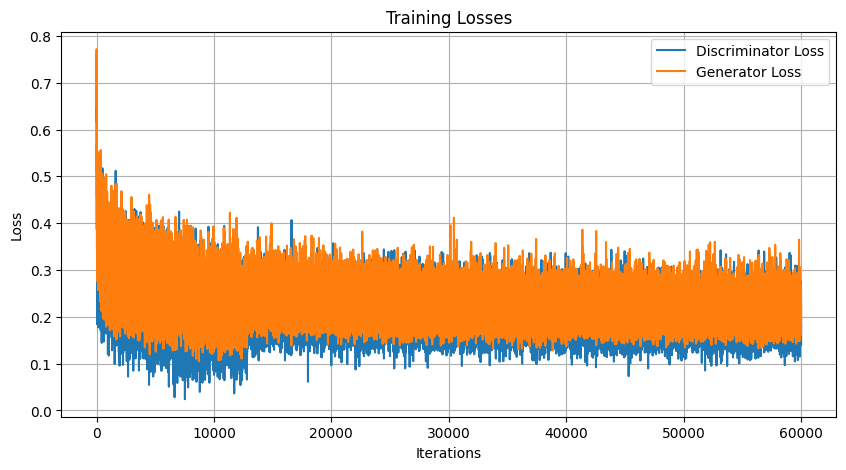

[3142/4000][125/125] Iter: 60000 Loss_D: 0.142492 Loss_G: 0.250022 |gD|: 4.2395e+00 |gG|: 3.6532e+00 Time(min): 36.93


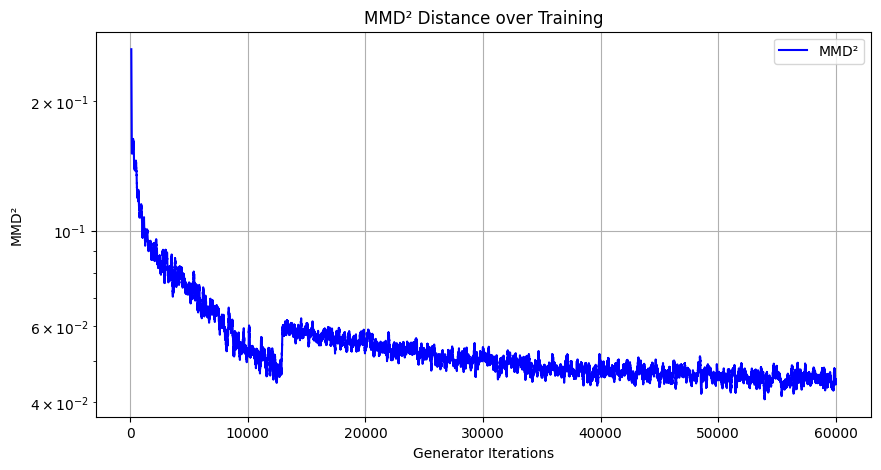

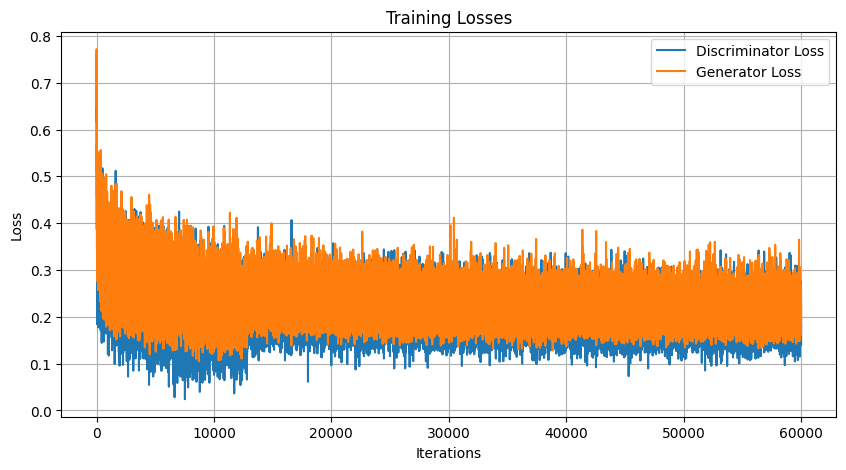

Training Epochs:  79%|███████▉  | 3169/4000 [37:14<09:49,  1.41it/s]

[3168/4000][90/125] Iter: 60500 Loss_D: 0.197121 Loss_G: 0.225456 |gD|: 2.6976e+00 |gG|: 2.5348e+00 Time(min): 37.25
[3168/4000][125/125] Iter: 60500 Loss_D: 0.278666 Loss_G: 0.225456 |gD|: 2.3002e+00 |gG|: 2.5348e+00 Time(min): 37.25


Training Epochs:  80%|███████▉  | 3195/4000 [37:31<08:31,  1.57it/s]

[3194/4000][90/125] Iter: 61000 Loss_D: 0.185704 Loss_G: 0.206791 |gD|: 1.0597e+00 |gG|: 2.6124e+00 Time(min): 37.53
[3194/4000][125/125] Iter: 61000 Loss_D: 0.182495 Loss_G: 0.206791 |gD|: 5.3169e+00 |gG|: 2.6124e+00 Time(min): 37.53


Training Epochs:  81%|████████  | 3221/4000 [37:49<08:52,  1.46it/s]

[3220/4000][90/125] Iter: 61500 Loss_D: 0.209591 Loss_G: 0.237846 |gD|: 2.7625e+00 |gG|: 2.9815e+00 Time(min): 37.82
[3220/4000][125/125] Iter: 61500 Loss_D: 0.184725 Loss_G: 0.237846 |gD|: 2.7083e+00 |gG|: 2.9815e+00 Time(min): 37.82


Training Epochs:  81%|████████  | 3247/4000 [38:06<08:29,  1.48it/s]

[3246/4000][90/125] Iter: 62000 Loss_D: 0.167449 Loss_G: 0.199333 |gD|: 2.5811e+00 |gG|: 3.2135e+00 Time(min): 38.11
[3246/4000][125/125] Iter: 62000 Loss_D: 0.167968 Loss_G: 0.199333 |gD|: 3.3383e+00 |gG|: 3.2135e+00 Time(min): 38.12


Training Epochs:  82%|████████▏ | 3273/4000 [38:24<08:04,  1.50it/s]

[3272/4000][90/125] Iter: 62500 Loss_D: 0.236620 Loss_G: 0.211760 |gD|: 2.5174e+00 |gG|: 3.2156e+00 Time(min): 38.41
[3272/4000][125/125] Iter: 62500 Loss_D: 0.168308 Loss_G: 0.211760 |gD|: 2.5355e+00 |gG|: 3.2156e+00 Time(min): 38.41


Training Epochs:  82%|████████▏ | 3299/4000 [38:41<07:48,  1.50it/s]

[3298/4000][90/125] Iter: 63000 Loss_D: 0.162566 Loss_G: 0.215905 |gD|: 4.5122e+00 |gG|: 3.2975e+00 Time(min): 38.69
[3298/4000][125/125] Iter: 63000 Loss_D: 0.181478 Loss_G: 0.215905 |gD|: 3.1201e+00 |gG|: 3.2975e+00 Time(min): 38.70


Training Epochs:  83%|████████▎ | 3325/4000 [38:59<07:25,  1.51it/s]

[3324/4000][90/125] Iter: 63500 Loss_D: 0.156505 Loss_G: 0.262416 |gD|: 3.7015e+00 |gG|: 3.6352e+00 Time(min): 38.99
[3324/4000][125/125] Iter: 63500 Loss_D: 0.195337 Loss_G: 0.262416 |gD|: 1.5034e+00 |gG|: 3.6352e+00 Time(min): 38.99


Training Epochs:  84%|████████▍ | 3350/4000 [39:16<07:20,  1.48it/s]

[3350/4000][90/125] Iter: 64000 Loss_D: 0.217146 Loss_G: 0.252267 |gD|: 3.4630e+00 |gG|: 4.7451e+00 Time(min): 39.28


Training Epochs:  84%|████████▍ | 3351/4000 [39:16<07:20,  1.47it/s]

[3350/4000][125/125] Iter: 64000 Loss_D: 0.186776 Loss_G: 0.252267 |gD|: 1.9512e+00 |gG|: 4.7451e+00 Time(min): 39.28


Training Epochs:  84%|████████▍ | 3377/4000 [39:34<06:58,  1.49it/s]

[3376/4000][90/125] Iter: 64500 Loss_D: 0.251667 Loss_G: 0.212862 |gD|: 2.9750e+00 |gG|: 2.3707e+00 Time(min): 39.57
[3376/4000][125/125] Iter: 64500 Loss_D: 0.138230 Loss_G: 0.212862 |gD|: 1.2307e+00 |gG|: 2.3707e+00 Time(min): 39.58


Training Epochs:  85%|████████▌ | 3402/4000 [39:51<07:04,  1.41it/s]

[3402/4000][90/125] Iter: 65000 Loss_D: 0.163766 Loss_G: 0.182025 |gD|: 4.2397e+00 |gG|: 2.1093e+00 Time(min): 39.87


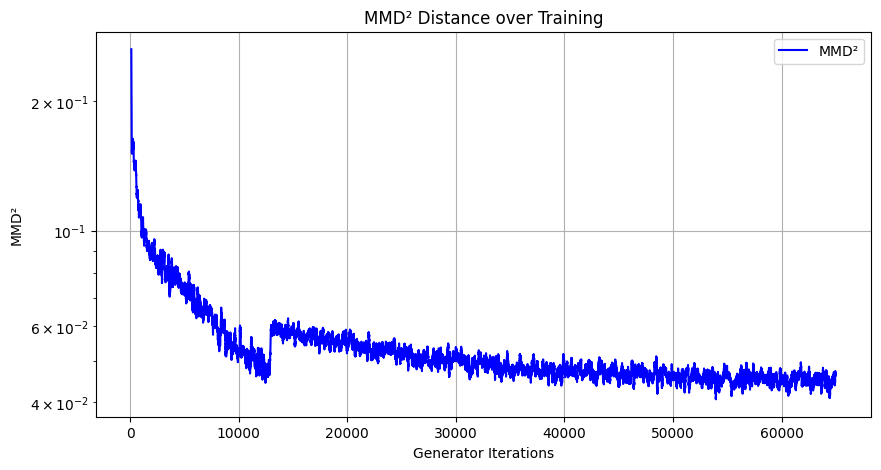

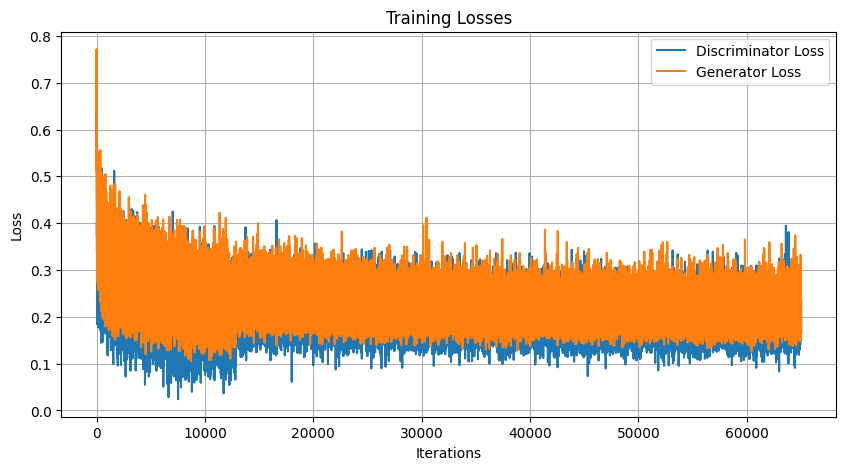

[3402/4000][125/125] Iter: 65000 Loss_D: 0.215592 Loss_G: 0.182025 |gD|: 4.0665e+00 |gG|: 2.1093e+00 Time(min): 39.89


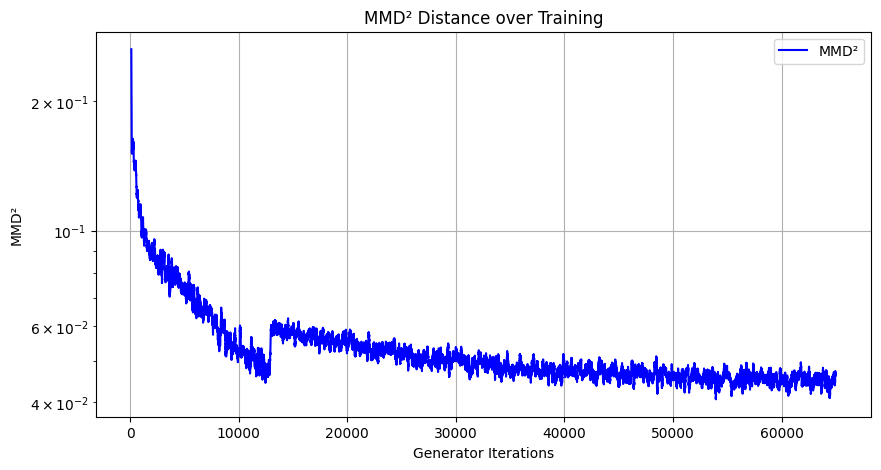

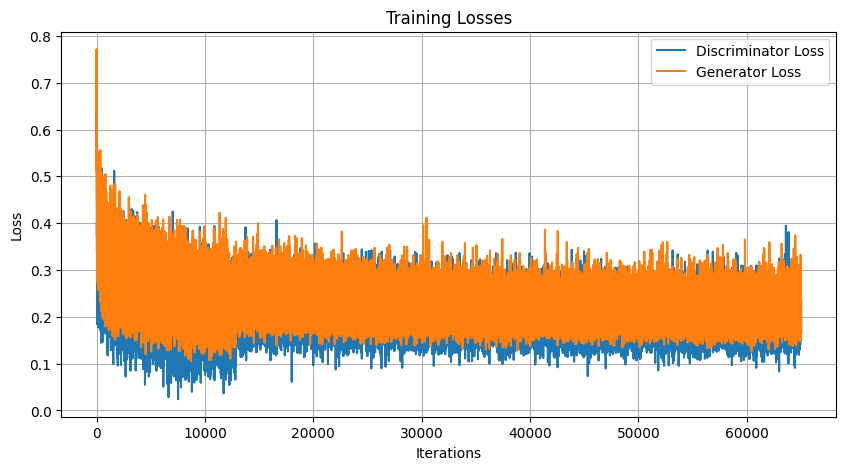

Training Epochs:  86%|████████▌ | 3429/4000 [40:12<06:33,  1.45it/s]

[3428/4000][90/125] Iter: 65500 Loss_D: 0.162722 Loss_G: 0.202806 |gD|: 6.0420e+00 |gG|: 3.8840e+00 Time(min): 40.20
[3428/4000][125/125] Iter: 65500 Loss_D: 0.195989 Loss_G: 0.202806 |gD|: 4.5329e+00 |gG|: 3.8840e+00 Time(min): 40.21


Training Epochs:  86%|████████▋ | 3455/4000 [40:30<06:07,  1.48it/s]

[3454/4000][90/125] Iter: 66000 Loss_D: 0.201220 Loss_G: 0.203205 |gD|: 2.4046e+00 |gG|: 2.7183e+00 Time(min): 40.50
[3454/4000][125/125] Iter: 66000 Loss_D: 0.183377 Loss_G: 0.203205 |gD|: 4.4826e+00 |gG|: 2.7183e+00 Time(min): 40.51


Training Epochs:  87%|████████▋ | 3481/4000 [40:47<05:53,  1.47it/s]

[3480/4000][90/125] Iter: 66500 Loss_D: 0.144525 Loss_G: 0.180906 |gD|: 3.0813e+00 |gG|: 2.5172e+00 Time(min): 40.79
[3480/4000][125/125] Iter: 66500 Loss_D: 0.166033 Loss_G: 0.180906 |gD|: 2.3240e+00 |gG|: 2.5172e+00 Time(min): 40.80


Training Epochs:  88%|████████▊ | 3507/4000 [41:05<05:39,  1.45it/s]

[3506/4000][90/125] Iter: 67000 Loss_D: 0.183533 Loss_G: 0.194796 |gD|: 2.6459e+00 |gG|: 3.6800e+00 Time(min): 41.10
[3506/4000][125/125] Iter: 67000 Loss_D: 0.133562 Loss_G: 0.194796 |gD|: 4.0344e+00 |gG|: 3.6800e+00 Time(min): 41.10


Training Epochs:  88%|████████▊ | 3533/4000 [41:23<05:26,  1.43it/s]

[3532/4000][90/125] Iter: 67500 Loss_D: 0.223197 Loss_G: 0.212232 |gD|: 1.4651e+00 |gG|: 2.3132e+00 Time(min): 41.40
[3532/4000][125/125] Iter: 67500 Loss_D: 0.220609 Loss_G: 0.212232 |gD|: 1.9938e+00 |gG|: 2.3132e+00 Time(min): 41.40


Training Epochs:  89%|████████▉ | 3559/4000 [41:41<04:56,  1.49it/s]

[3558/4000][90/125] Iter: 68000 Loss_D: 0.277375 Loss_G: 0.209896 |gD|: 2.0146e+00 |gG|: 3.0626e+00 Time(min): 41.69
[3558/4000][125/125] Iter: 68000 Loss_D: 0.164155 Loss_G: 0.209896 |gD|: 3.8595e+00 |gG|: 3.0626e+00 Time(min): 41.69


Training Epochs:  90%|████████▉ | 3585/4000 [41:58<04:37,  1.49it/s]

[3584/4000][90/125] Iter: 68500 Loss_D: 0.186985 Loss_G: 0.196940 |gD|: 1.4696e+00 |gG|: 2.4929e+00 Time(min): 41.98
[3584/4000][125/125] Iter: 68500 Loss_D: 0.194909 Loss_G: 0.196940 |gD|: 2.4428e+00 |gG|: 2.4929e+00 Time(min): 41.98


Training Epochs:  90%|█████████ | 3611/4000 [42:16<04:23,  1.48it/s]

[3610/4000][90/125] Iter: 69000 Loss_D: 0.193353 Loss_G: 0.194635 |gD|: 2.4376e+00 |gG|: 3.0959e+00 Time(min): 42.27
[3610/4000][125/125] Iter: 69000 Loss_D: 0.206490 Loss_G: 0.194635 |gD|: 2.8802e+00 |gG|: 3.0959e+00 Time(min): 42.28


Training Epochs:  91%|█████████ | 3637/4000 [42:33<03:53,  1.56it/s]

[3636/4000][90/125] Iter: 69500 Loss_D: 0.202929 Loss_G: 0.184423 |gD|: 2.2609e+00 |gG|: 3.0157e+00 Time(min): 42.56
[3636/4000][125/125] Iter: 69500 Loss_D: 0.193109 Loss_G: 0.184423 |gD|: 1.7681e+00 |gG|: 3.0157e+00 Time(min): 42.56


Training Epochs:  92%|█████████▏| 3662/4000 [42:51<03:51,  1.46it/s]

[3662/4000][90/125] Iter: 70000 Loss_D: 0.156455 Loss_G: 0.231007 |gD|: 3.2367e+00 |gG|: 2.1821e+00 Time(min): 42.86


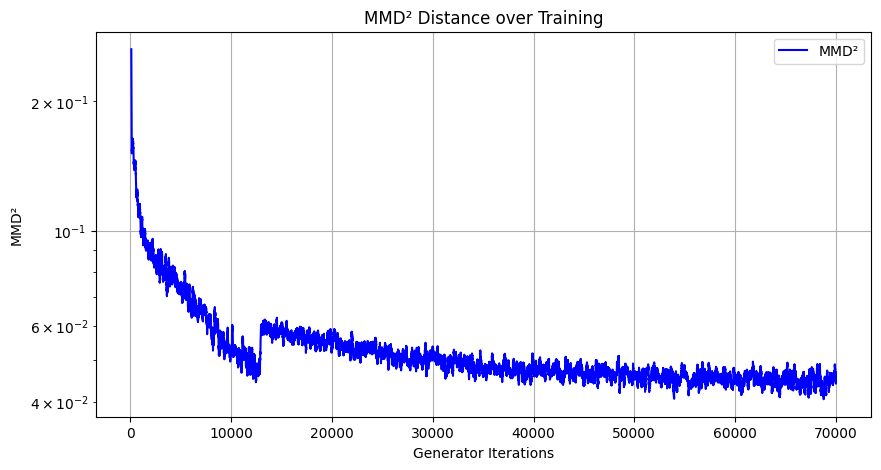

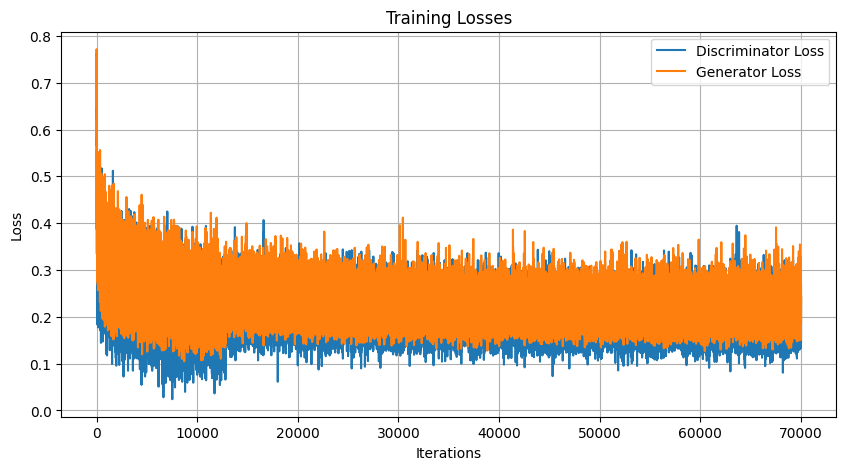

[3662/4000][125/125] Iter: 70000 Loss_D: 0.167583 Loss_G: 0.231007 |gD|: 4.2048e+00 |gG|: 2.1821e+00 Time(min): 42.88


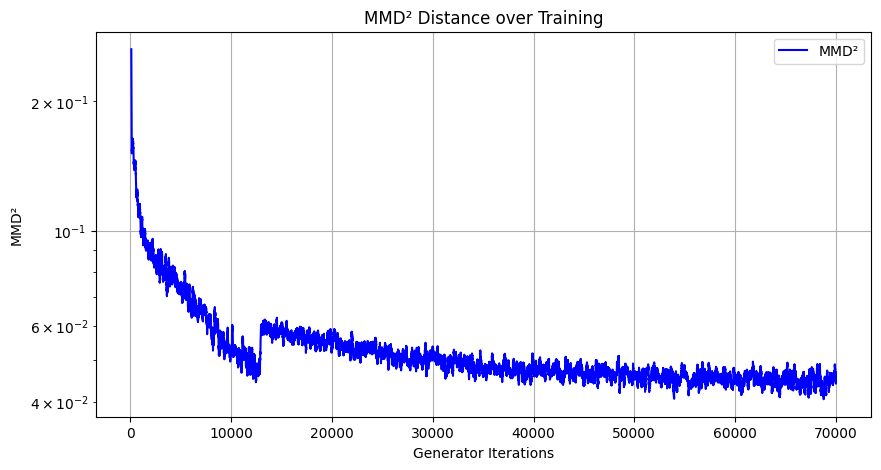

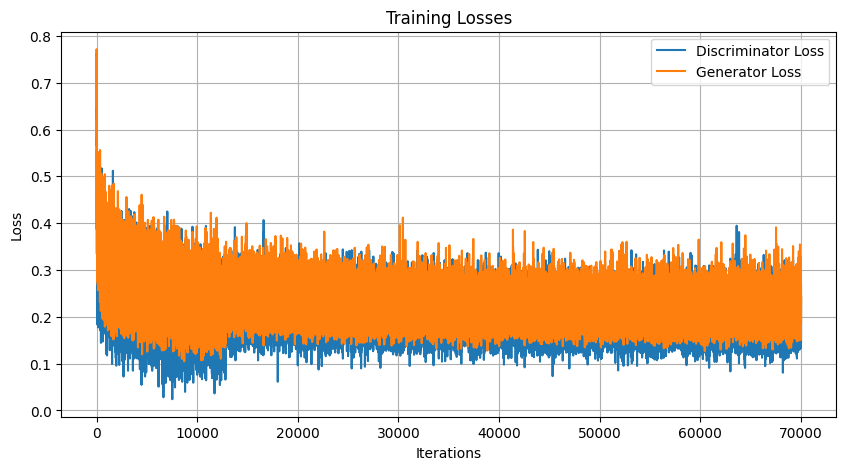

Training Epochs:  92%|█████████▏| 3689/4000 [43:12<03:35,  1.44it/s]

[3688/4000][90/125] Iter: 70500 Loss_D: 0.179720 Loss_G: 0.186926 |gD|: 3.0048e+00 |gG|: 2.7088e+00 Time(min): 43.20
[3688/4000][125/125] Iter: 70500 Loss_D: 0.194284 Loss_G: 0.186926 |gD|: 3.0432e+00 |gG|: 2.7088e+00 Time(min): 43.20


Training Epochs:  93%|█████████▎| 3715/4000 [43:29<03:13,  1.47it/s]

[3714/4000][90/125] Iter: 71000 Loss_D: 0.160935 Loss_G: 0.240690 |gD|: 2.3364e+00 |gG|: 4.0391e+00 Time(min): 43.49
[3714/4000][125/125] Iter: 71000 Loss_D: 0.125396 Loss_G: 0.240690 |gD|: 8.1639e+00 |gG|: 4.0391e+00 Time(min): 43.49


Training Epochs:  94%|█████████▎| 3741/4000 [43:47<02:51,  1.51it/s]

[3740/4000][90/125] Iter: 71500 Loss_D: 0.283904 Loss_G: 0.188997 |gD|: 2.9488e+00 |gG|: 2.9667e+00 Time(min): 43.79
[3740/4000][125/125] Iter: 71500 Loss_D: 0.195699 Loss_G: 0.188997 |gD|: 1.8706e+00 |gG|: 2.9667e+00 Time(min): 43.79


Training Epochs:  94%|█████████▍| 3767/4000 [44:04<02:35,  1.49it/s]

[3766/4000][90/125] Iter: 72000 Loss_D: 0.133934 Loss_G: 0.219980 |gD|: 2.2665e+00 |gG|: 4.4756e+00 Time(min): 44.08
[3766/4000][125/125] Iter: 72000 Loss_D: 0.253155 Loss_G: 0.219980 |gD|: 1.5954e+00 |gG|: 4.4756e+00 Time(min): 44.08


Training Epochs:  95%|█████████▍| 3793/4000 [44:22<02:17,  1.50it/s]

[3792/4000][90/125] Iter: 72500 Loss_D: 0.232324 Loss_G: 0.215107 |gD|: 2.2489e+00 |gG|: 2.8472e+00 Time(min): 44.37
[3792/4000][125/125] Iter: 72500 Loss_D: 0.210563 Loss_G: 0.215107 |gD|: 4.7999e+00 |gG|: 2.8472e+00 Time(min): 44.37


Training Epochs:  95%|█████████▌| 3819/4000 [44:39<02:00,  1.51it/s]

[3818/4000][90/125] Iter: 73000 Loss_D: 0.167903 Loss_G: 0.241531 |gD|: 3.6080e+00 |gG|: 3.1204e+00 Time(min): 44.65
[3818/4000][125/125] Iter: 73000 Loss_D: 0.221771 Loss_G: 0.241531 |gD|: 2.6605e+00 |gG|: 3.1204e+00 Time(min): 44.66


Training Epochs:  96%|█████████▌| 3845/4000 [44:57<01:41,  1.52it/s]

[3844/4000][90/125] Iter: 73500 Loss_D: 0.181102 Loss_G: 0.187498 |gD|: 2.8952e+00 |gG|: 2.1696e+00 Time(min): 44.95
[3844/4000][125/125] Iter: 73500 Loss_D: 0.218212 Loss_G: 0.187498 |gD|: 1.8722e+00 |gG|: 2.1696e+00 Time(min): 44.95


Training Epochs:  97%|█████████▋| 3870/4000 [45:13<01:27,  1.49it/s]

[3870/4000][90/125] Iter: 74000 Loss_D: 0.144786 Loss_G: 0.280721 |gD|: 2.3700e+00 |gG|: 3.9962e+00 Time(min): 45.24


Training Epochs:  97%|█████████▋| 3871/4000 [45:14<01:31,  1.41it/s]

[3870/4000][125/125] Iter: 74000 Loss_D: 0.196934 Loss_G: 0.280721 |gD|: 2.0280e+00 |gG|: 3.9962e+00 Time(min): 45.24


Training Epochs:  97%|█████████▋| 3897/4000 [45:32<01:09,  1.48it/s]

[3896/4000][90/125] Iter: 74500 Loss_D: 0.167114 Loss_G: 0.194386 |gD|: 1.3979e+00 |gG|: 2.0959e+00 Time(min): 45.54
[3896/4000][125/125] Iter: 74500 Loss_D: 0.172466 Loss_G: 0.194386 |gD|: 8.2840e-01 |gG|: 2.0959e+00 Time(min): 45.54


Training Epochs:  98%|█████████▊| 3922/4000 [45:49<00:52,  1.48it/s]

[3922/4000][90/125] Iter: 75000 Loss_D: 0.173751 Loss_G: 0.203997 |gD|: 2.3087e+00 |gG|: 3.3706e+00 Time(min): 45.83


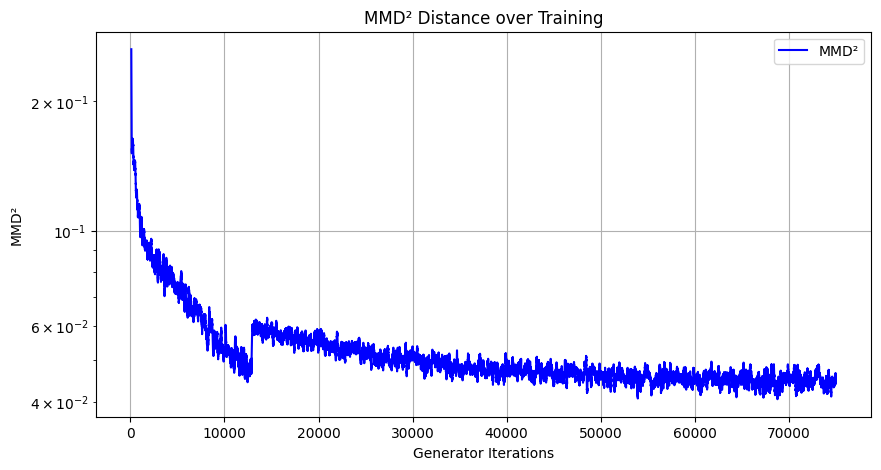

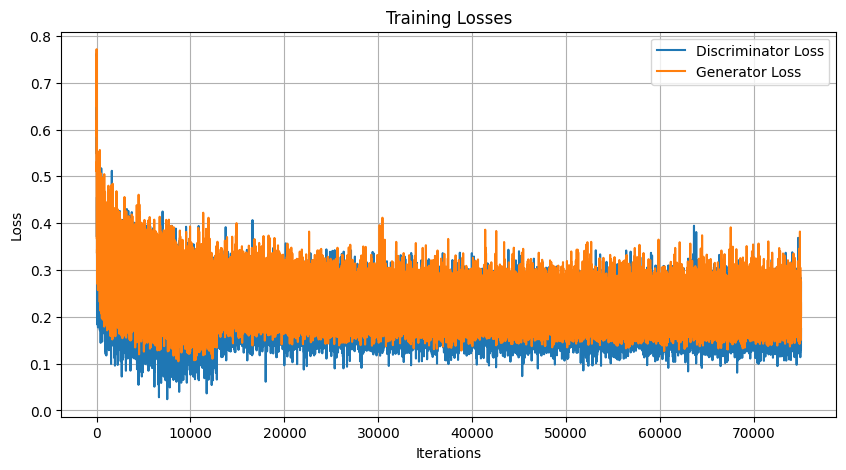

[3922/4000][125/125] Iter: 75000 Loss_D: 0.182006 Loss_G: 0.203997 |gD|: 3.1798e+00 |gG|: 3.3706e+00 Time(min): 45.86


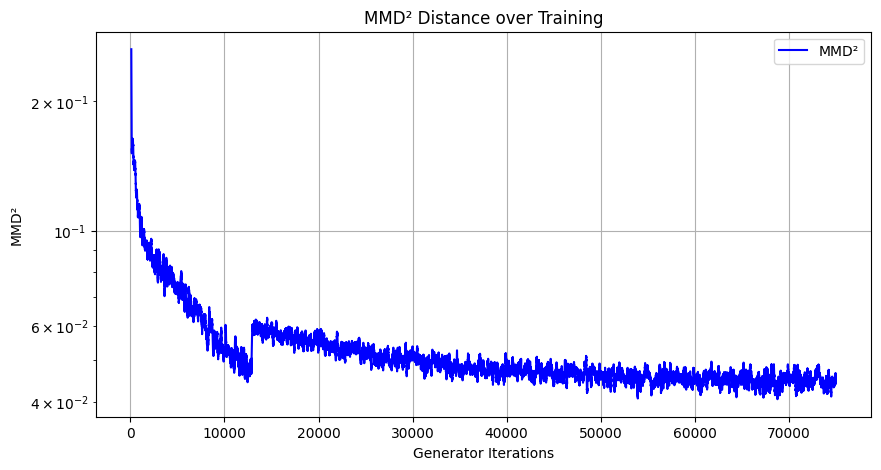

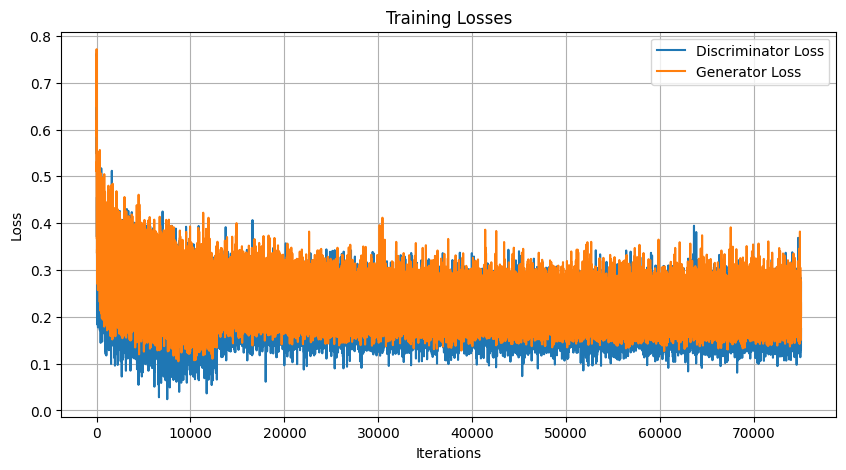

Training Epochs:  99%|█████████▊| 3949/4000 [46:10<00:35,  1.46it/s]

[3948/4000][90/125] Iter: 75500 Loss_D: 0.165977 Loss_G: 0.169362 |gD|: 2.6788e+00 |gG|: 2.4715e+00 Time(min): 46.17
[3948/4000][125/125] Iter: 75500 Loss_D: 0.215541 Loss_G: 0.169362 |gD|: 2.7766e+00 |gG|: 2.4715e+00 Time(min): 46.17


Training Epochs:  99%|█████████▉| 3975/4000 [46:27<00:16,  1.51it/s]

[3974/4000][90/125] Iter: 76000 Loss_D: 0.134325 Loss_G: 0.216537 |gD|: 2.3641e+00 |gG|: 3.6572e+00 Time(min): 46.46
[3974/4000][125/125] Iter: 76000 Loss_D: 0.173078 Loss_G: 0.216537 |gD|: 2.0054e+00 |gG|: 3.6572e+00 Time(min): 46.46


Training Epochs: 100%|██████████| 4000/4000 [46:44<00:00,  1.43it/s]


In [7]:
from models.mmd_gan_non_image.train_mmd_gan_non_image import train_mmd_gan_vector 
# 
MMD_GAN_SAVE_PATH = model_dir + "/mmd_gan_control_multivariate_gaussian.pth"
EPOCHS = 4000
%matplotlib inline
trainloader, testloader, min_value, max_value = load_control(control_data, batch_size=64)
# netG, netD, losses_D, losses_G, mmd2_values, iterations = train_mmd_gan_vector(trainloader, N_INP, latent_dim=NOISE_SIZE, max_iter=100, batch_size = 64, experiment_name="control_presentation", sigma_list=sigmas)
netG, netD, losses_D, losses_G, mmd2_values, iterations = train_mmd_gan_vector(trainloader, N_INP, latent_dim=10, hidden_dims_enc=[1024], hidden_dims_dec=[1024], batch_size=64, max_iter=EPOCHS, experiment_name='mmdgan_experiment', sigma_list=sigmas)

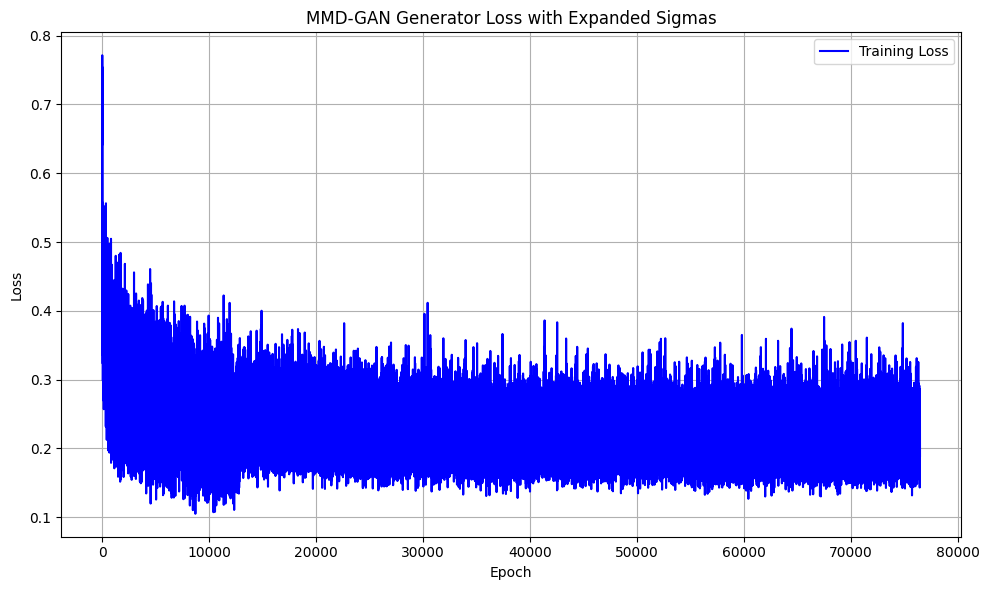

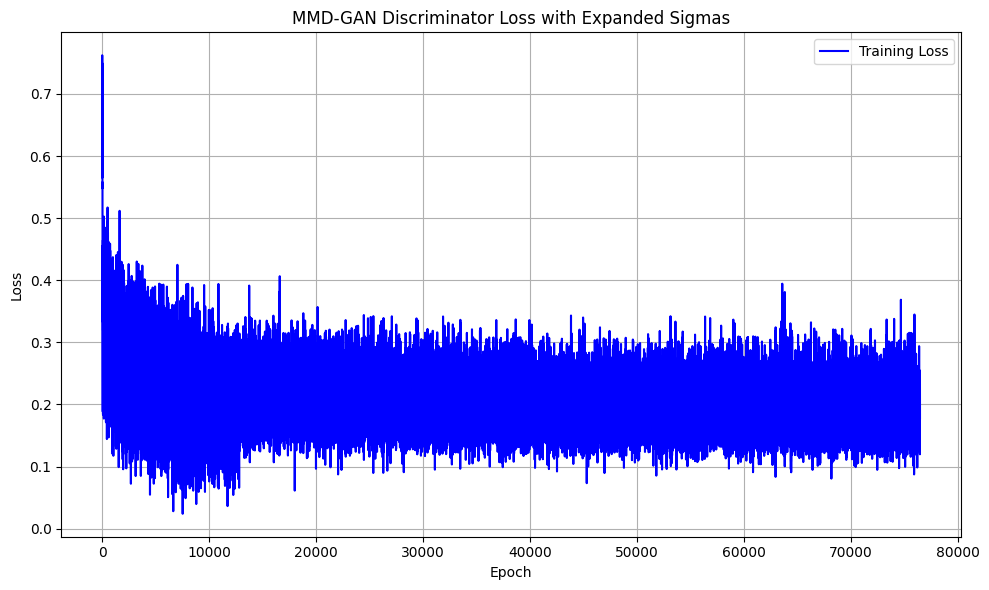

In [8]:
plot_loss(losses_G, title="MMD-GAN Generator Loss with Expanded Sigmas")
plot_loss(losses_D, title="MMD-GAN Discriminator Loss with Expanded Sigmas")

## Sample Visualizations

##### MNIST 1-D
**Run only if data used is MNIST-1D**

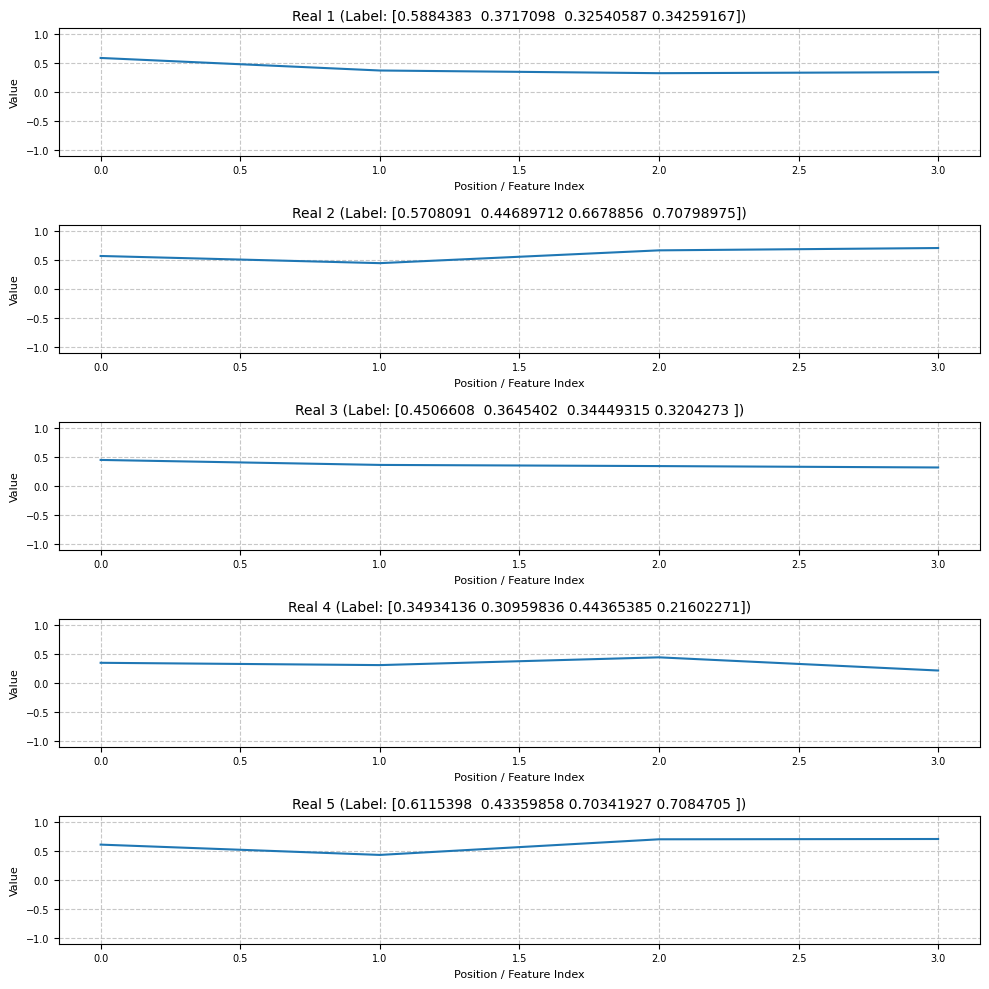

In [9]:
from visualization.visualize_1d_data import visualize_mnist1d
from models.gmmn.gmmn import generate_gmmn_samples

samples, labels = next(iter(trainloader))
visualize_mnist1d(samples, labels, title_prefix="Real")

In [10]:
gen_samples = generate_gmmn_samples(gmm_net, autoencoder, NOISE_SIZE, 10)
visualize_mnist1d(gen_samples, labels, title_prefix="Generated")

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

##### Control Data
**Work only if working with control data**

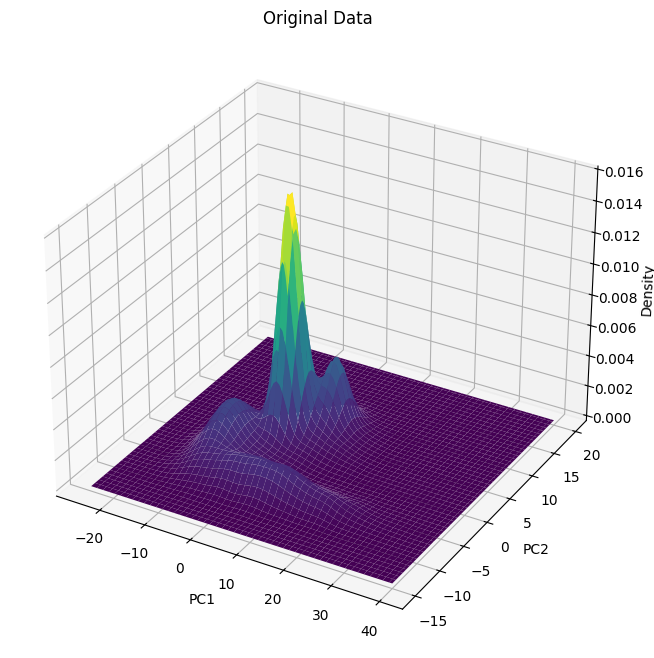

In [12]:
import visualization.plots
%matplotlib inline
visualization.plots.plot_3d_kde(control_data, "Original Data", bounds=(-25, 40, -15, 20))

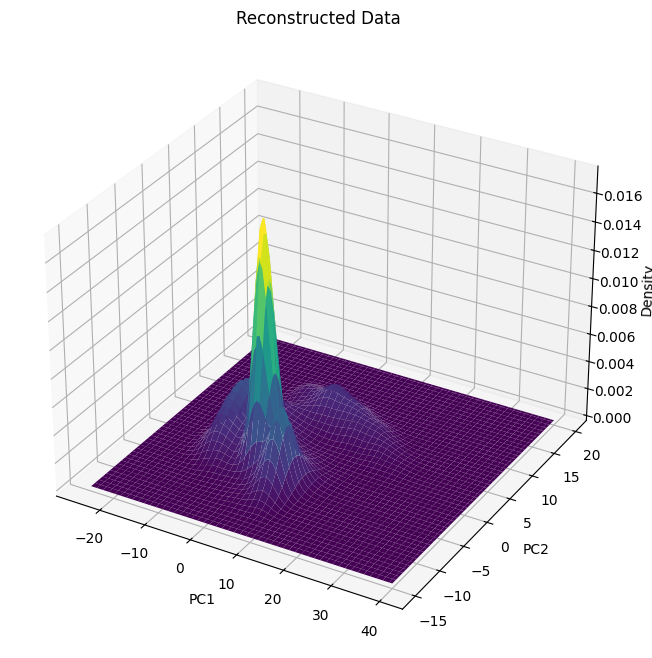

In [ ]:
reconstructed_data = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder.to(device) # Move model to device

with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(trainloader):
        data = data.to(device) # Move data to device
        reconstructed_data.append(autoencoder.forward(data)[1].cpu())
reconstructed_data = torch.cat(reconstructed_data, dim=0).numpy()
reconstructed_data = np.add(np.multiply(max_value - min_value, reconstructed_data), min_value)
visualization.plots.plot_3d_kde(reconstructed_data, "Reconstructed Data",  bounds=(-25, 40, -15, 20))

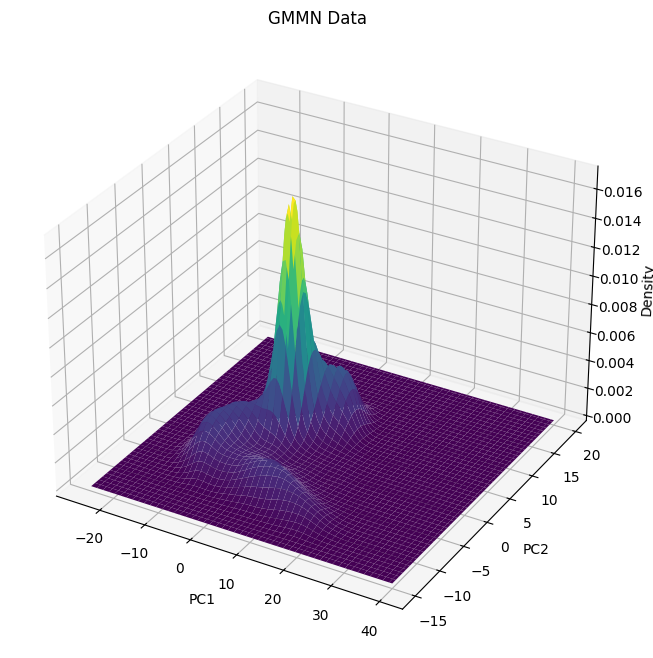

In [ ]:
from models.gmmn.gmmn import generate_gmmn_samples
gen_samples = generate_gmmn_samples(gmm_net, autoencoder, NOISE_SIZE, 10000, device=device)
gen_samples = np.add(np.multiply(max_value - min_value, gen_samples), min_value)
visualization.plots.plot_3d_kde(gen_samples, "GMMN Data", bounds=(-25, 40, -15, 20))

In [11]:
    
def generate_mmd_gan(model, NOISE_SIZE, number, device='cpu'):
    model.eval()
    model.to(device) 

    generated_samples = []

    with torch.no_grad(): # Disable gradient calculations for inference
        for _ in range(number):
            noise = torch.randn((1, NOISE_SIZE)) 
            noise = noise.to(device) # Move noise to the same device as the model
            sample = model(noise)
            generated_samples.append(sample.cpu()) # Move generated sample to CPU for storage

    # Concatenate all generated samples into a single tensor
    return torch.squeeze(torch.cat(generated_samples, dim=0)).numpy()

gen_samples = generate_mmd_gan(netG, 10, 10000, device=device)
# print(gen_samples[:10])
gen_samples = np.add(np.multiply(max_value - min_value, gen_samples), min_value)

visualization.plots.plot_3d_kde(gen_samples, "MMD-GAN Data", bounds=(-25, 40, -15, 20))

NameError: name 'visualization' is not defined

## Bootstrapping Hypothesis Test

In [ ]:
from utilities.bootstrapping_test import bootstrap_hypothesis_test

original_data = []
for batch_idx, (data, labels) in enumerate(trainloader):
    original_data.append(data.cpu()) # .cpu() if data is on GPU
original_data = torch.cat(original_data, dim=0)
original_data = np.squeeze(original_data.numpy())
generating_function = generate_gmmn_samples
gen_args = (gmm_net, autoencoder, NOISE_SIZE, 20000)
alpha = 0.05
num_iterations = 1000

bootstrap_hypothesis_test(original_data, generating_function, gen_args, alpha, num_iterations)